# PopSimPrep Validation Notebook

This notebook validates the PopulationSim results and downstream data products.

## Features
- Validates census control totals vs. generated population
- Checks cell consistency across all datasets
- Validates buildings_with_mid_data.gpkg
- Validates wege_temp_chunks/ (parquet chunks)
- Cross-dataset H_ID consistency
- Nice summary plots

## Usage
Just set the paths in the Configuration section - everything else is auto-detected.

## 1. Configuration

Set the paths to your data files. The notebook will auto-detect control columns and other settings.

In [ ]:
from pathlib import Path

# ============================================================================
# CONFIGURATION - Set your paths here
# ============================================================================

# Project root directory
PROJECT_ROOT = Path("..")  # Adjust if running from different location

# PopSim data directory (contains control_totals_*.csv, geo_cross_walk.csv)
POPSIM_DATA_DIR = PROJECT_ROOT / "popsim" / "data"

# PopSim config directory (contains _prep3_controls.csv)
POPSIM_CONFIG_DIR = PROJECT_ROOT / "popsim" / "configs"

# Combined expanded household IDs
EXPANDED_HH_FILE = PROJECT_ROOT / "popsim_combined" / "final_expanded_household_ids_combined.csv"

# Output files from downstream processing
BUILDINGS_GPKG = PROJECT_ROOT / "buildings_with_mid_data.gpkg"
WEGE_CHUNKS_DIR = PROJECT_ROOT / "wege_temp_chunks"

# Output directory for validation results
OUTPUT_DIR = PROJECT_ROOT / "validation_results"

# ============================================================================
# Auto-detected paths (don't change unless needed)
# ============================================================================
CONTROL_100M_FILE = POPSIM_DATA_DIR / "control_totals_ZENSUS100m.csv"
CONTROL_1KM_FILE = POPSIM_DATA_DIR / "control_totals_ZENSUS1km.csv"
GEO_CROSSWALK_FILE = POPSIM_DATA_DIR / "geo_cross_walk.csv"
CONTROLS_CONFIG_FILE = POPSIM_CONFIG_DIR / "_prep3_controls.csv"

# Create output directory
OUTPUT_DIR.mkdir(exist_ok=True)

print("Configuration loaded.")
print(f"  Project root: {PROJECT_ROOT.resolve()}")
print(f"  Output dir: {OUTPUT_DIR.resolve()}")

Configuration loaded.
  Project root: /workspaces/popsimprep
  Output dir: /workspaces/popsimprep/validation_results


## 2. Import Packages & Setup

In [2]:
import json
import warnings
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: geopandas for gpkg
try:
    import geopandas as gpd
    HAS_GEOPANDAS = True
except ImportError:
    HAS_GEOPANDAS = False
    print("Warning: geopandas not available. GPKG validation will be limited.")

# Matplotlib setup
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['font.size'] = 10

# Pandas display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 200)

warnings.filterwarnings('ignore', category=FutureWarning)

print("Packages loaded successfully.")

Packages loaded successfully.


## 3. Load Data Files

In [3]:
def check_file_exists(path, name):
    """Check if file exists and print status."""
    exists = path.exists()
    status = "OK" if exists else "MISSING"
    print(f"  [{status}] {name}: {path}")
    return exists

print("Checking data files...")
files_ok = all([
    check_file_exists(CONTROL_100M_FILE, "Control totals 100m"),
    check_file_exists(CONTROL_1KM_FILE, "Control totals 1km"),
    check_file_exists(GEO_CROSSWALK_FILE, "Geo crosswalk"),
    check_file_exists(CONTROLS_CONFIG_FILE, "Controls config"),
    check_file_exists(EXPANDED_HH_FILE, "Expanded HH IDs"),
    check_file_exists(BUILDINGS_GPKG, "Buildings GPKG"),
    check_file_exists(WEGE_CHUNKS_DIR, "Wege Chunks Dir"),
])

if not files_ok:
    print("\nWARNING: Some files are missing. Validation may be incomplete.")

Checking data files...
  [OK] Control totals 100m: ../popsim/data/control_totals_ZENSUS100m.csv
  [OK] Control totals 1km: ../popsim/data/control_totals_ZENSUS1km.csv
  [OK] Geo crosswalk: ../popsim/data/geo_cross_walk.csv
  [OK] Controls config: ../popsim/configs/_prep3_controls.csv
  [OK] Expanded HH IDs: ../popsim_combined/final_expanded_household_ids_combined.csv
  [OK] Buildings GPKG: ../buildings_with_mid_data.gpkg
  [OK] Wege Parquet: ../wege_with_home_coords.parquet


In [4]:
# Load control totals
print("Loading control totals...")
ctrl_100m = pd.read_csv(CONTROL_100M_FILE, dtype={'ZENSUS100m': str})
ctrl_1km = pd.read_csv(CONTROL_1KM_FILE, dtype={'ZENSUS1km': str})
print(f"  100m controls: {len(ctrl_100m):,} cells, {len(ctrl_100m.columns)} columns")
print(f"  1km controls: {len(ctrl_1km):,} cells, {len(ctrl_1km.columns)} columns")

# Load geo crosswalk
print("\nLoading geo crosswalk...")
geo_xwalk = pd.read_csv(GEO_CROSSWALK_FILE, dtype=str)
print(f"  Crosswalk: {len(geo_xwalk):,} cells")
print(f"  Columns: {list(geo_xwalk.columns)}")

# Load controls config
print("\nLoading controls config...")
controls_config = pd.read_csv(CONTROLS_CONFIG_FILE, sep=';')
print(f"  Config: {len(controls_config)} control definitions")

# Load expanded household IDs
print("\nLoading expanded household IDs...")
expanded_hh = pd.read_csv(EXPANDED_HH_FILE, dtype={'ZENSUS100m': str, 'ZENSUS1km': str, 'H_ID': int})
print(f"  Expanded HH: {len(expanded_hh):,} rows")
print(f"  Unique H_IDs: {expanded_hh['H_ID'].nunique():,}")
print(f"  Unique 100m cells: {expanded_hh['ZENSUS100m'].nunique():,}")

Loading control totals...
  100m controls: 425,907 cells, 573 columns
  1km controls: 30,146 cells, 563 columns

Loading geo crosswalk...
  Crosswalk: 425,907 cells
  Columns: ['ZENSUS100m', 'ZENSUS1km', 'STAAT', 'WELT']

Loading controls config...
  Config: 44 control definitions

Loading expanded household IDs...
  Expanded HH: 3,803,578 rows
  Unique H_IDs: 130,068
  Unique 100m cells: 329,837


## 4. Parse Control Configuration

Extract control column definitions from the config file.

In [5]:
# Parse control definitions
control_defs = []

for _, row in controls_config.iterrows():
    control_defs.append({
        'target': row['target'],
        'geography': row['geography'],
        'seed_table': row['seed_table'],
        'importance': row['importance'],
        'control_field': row['control_field'],
        'expression': row['expression'],
    })

# Group by geography
controls_by_geog = defaultdict(list)
for cd in control_defs:
    controls_by_geog[cd['geography']].append(cd)

print("Control definitions parsed:")
for geog, controls in controls_by_geog.items():
    print(f"  {geog}: {len(controls)} controls")
    for c in controls[:3]:
        print(f"    - {c['control_field']} ({c['seed_table']})")
    if len(controls) > 3:
        print(f"    ... and {len(controls) - 3} more")

Control definitions parsed:
  ZENSUS100m: 22 controls
    - Insgesamt_Haushalte_Groesse_des_privaten_Haushalts_100m_Gitter_adj_ZENSUS100m (households)
    - POP_TOTAL_100m_adj_ZENSUS100m (persons)
    - M_AGE_0_9_agg_ZENSUS100m (persons)
    ... and 19 more
  ZENSUS1km: 22 controls
    - Insgesamt_Haushalte_Groesse_des_privaten_Haushalts_100m_Gitter_adj_ZENSUS1km (households)
    - POP_TOTAL_100m_adj_ZENSUS1km (persons)
    - M_AGE_0_9_agg_ZENSUS1km (persons)
    ... and 19 more


In [6]:
# Extract key control columns for validation
KEY_CONTROLS_100M = [
    'Insgesamt_Haushalte_Groesse_des_privaten_Haushalts_100m_Gitter_adj_ZENSUS100m',
    'POP_TOTAL_100m_adj_ZENSUS100m',
    'M_TOTAL_ZENSUS100m',
    'F_TOTAL_ZENSUS100m',
]

# Age-sex controls
AGE_LABELS = ['0_9', '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_plus']
for label in AGE_LABELS:
    KEY_CONTROLS_100M.append(f'M_AGE_{label}_agg_ZENSUS100m')
    KEY_CONTROLS_100M.append(f'F_AGE_{label}_agg_ZENSUS100m')

# Verify these columns exist
missing_cols = [c for c in KEY_CONTROLS_100M if c not in ctrl_100m.columns]
if missing_cols:
    print(f"WARNING: Missing control columns: {missing_cols}")
else:
    print(f"All {len(KEY_CONTROLS_100M)} key control columns found in 100m data.")

All 22 key control columns found in 100m data.


## 5. Cell Consistency Checks

Verify that cells are consistent across all datasets.

In [7]:
# Get cell sets from each source
cells_geo = set(geo_xwalk['ZENSUS100m'])
cells_ctrl = set(ctrl_100m['ZENSUS100m'])
cells_expanded = set(expanded_hh['ZENSUS100m'])

print("Cell counts by source:")
print(f"  Geo crosswalk:    {len(cells_geo):,}")
print(f"  Control totals:   {len(cells_ctrl):,}")
print(f"  Expanded HH:      {len(cells_expanded):,}")

# Check consistency
print("\nConsistency checks:")

# Geo vs Controls
geo_not_in_ctrl = cells_geo - cells_ctrl
ctrl_not_in_geo = cells_ctrl - cells_geo
print(f"  Geo not in controls: {len(geo_not_in_ctrl)}")
print(f"  Controls not in geo: {len(ctrl_not_in_geo)}")

# Expanded vs Geo
exp_not_in_geo = cells_expanded - cells_geo
geo_not_in_exp = cells_geo - cells_expanded
print(f"  Expanded not in geo: {len(exp_not_in_geo)}")
print(f"  Geo not in expanded: {len(geo_not_in_exp)}")

# Common cells
common_cells = cells_geo & cells_ctrl & cells_expanded
print(f"\nCommon cells across all sources: {len(common_cells):,}")

Cell counts by source:
  Geo crosswalk:    425,907
  Control totals:   425,907
  Expanded HH:      329,837

Consistency checks:
  Geo not in controls: 0
  Controls not in geo: 0
  Expanded not in geo: 0
  Geo not in expanded: 96070

Common cells across all sources: 329,837


In [8]:
# Check for cells with control > 0 but no expanded HH
hh_control_col = 'Insgesamt_Haushalte_Groesse_des_privaten_Haushalts_100m_Gitter_adj_ZENSUS100m'

cells_with_hh = set(ctrl_100m[ctrl_100m[hh_control_col] > 0]['ZENSUS100m'])
cells_missing_hh = cells_with_hh - cells_expanded

print(f"Cells with HH control > 0: {len(cells_with_hh):,}")
print(f"Cells with HH control > 0 but no expanded HH: {len(cells_missing_hh)}")

if cells_missing_hh:
    print("\nSample missing cells:")
    sample_missing = list(cells_missing_hh)[:5]
    for cell in sample_missing:
        hh_ctrl = ctrl_100m[ctrl_100m['ZENSUS100m'] == cell][hh_control_col].values[0]
        print(f"  {cell}: HH control = {hh_ctrl:.1f}")

Cells with HH control > 0: 331,609
Cells with HH control > 0 but no expanded HH: 1772

Sample missing cells:
  CRS3035RES100mN3201200E4346900: HH control = 9.9
  CRS3035RES100mN3289600E4258800: HH control = 6.3
  CRS3035RES100mN3279500E4261600: HH control = 2.8
  CRS3035RES100mN3285200E4264500: HH control = 3.4
  CRS3035RES100mN3282900E4259900: HH control = 9.3


## 6. Control Totals Validation

Compare expanded HH counts with control totals at 100m and 1km levels.

In [9]:
# Aggregate expanded HH by 100m cell
hh_by_cell = expanded_hh.groupby('ZENSUS100m').agg(
    hh_count=('H_ID', 'count'),
    unique_hh=('H_ID', 'nunique')
).reset_index()

print(f"Aggregated HH by 100m cell: {len(hh_by_cell):,} cells")

# Merge with controls
validation_100m = ctrl_100m[['ZENSUS100m', hh_control_col]].merge(
    hh_by_cell, on='ZENSUS100m', how='left'
).fillna(0)

validation_100m['diff'] = validation_100m['hh_count'] - validation_100m[hh_control_col]
validation_100m['pct_diff'] = (validation_100m['diff'] / validation_100m[hh_control_col].replace(0, np.nan)) * 100

print(f"\nHousehold validation summary (100m level):")
print(f"  Total control HH: {validation_100m[hh_control_col].sum():,.0f}")
print(f"  Total expanded HH: {validation_100m['hh_count'].sum():,.0f}")
print(f"  Difference: {validation_100m['diff'].sum():,.0f}")
print(f"  Pct difference: {validation_100m['diff'].sum() / validation_100m[hh_control_col].sum() * 100:.3f}%")

Aggregated HH by 100m cell: 329,837 cells

Household validation summary (100m level):
  Total control HH: 3,816,448
  Total expanded HH: 3,803,578
  Difference: -12,870
  Pct difference: -0.337%


In [10]:
# Per-cell statistics
print("Per-cell difference statistics:")
print(validation_100m['diff'].describe())

# Cells with large differences
large_diff = validation_100m[abs(validation_100m['diff']) > 5]
print(f"\nCells with |diff| > 5: {len(large_diff)}")

if len(large_diff) > 0:
    print("\nTop 10 cells with largest differences:")
    print(large_diff.nlargest(10, 'diff')[['ZENSUS100m', hh_control_col, 'hh_count', 'diff']])

Per-cell difference statistics:
count    425907.000000
mean         -0.030219
std           0.712445
min         -66.567320
25%          -0.117623
50%           0.000000
75%           0.066882
max          45.990440
Name: diff, dtype: float64

Cells with |diff| > 5: 1098

Top 10 cells with largest differences:
                            ZENSUS100m  Insgesamt_Haushalte_Groesse_des_privaten_Haushalts_100m_Gitter_adj_ZENSUS100m  hh_count       diff
3920    CRS3035RES100mN3155600E4319000                                         116.009560                                 162.0  45.990440
217724  CRS3035RES100mN3301400E4195900                                           7.998187                                  47.0  39.001813
91761   CRS3035RES100mN3244300E4358300                                           8.491753                                  47.0  38.508247
127558  CRS3035RES100mN3257300E4295800                                          33.704823                                  71.0  37.

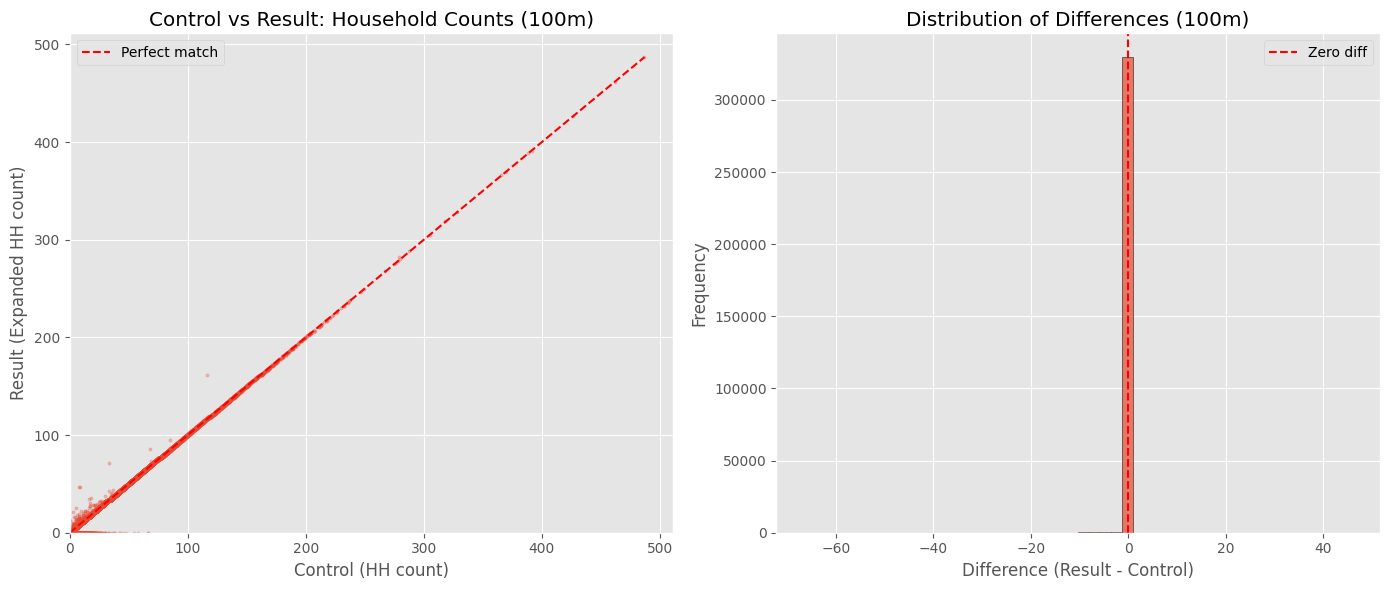

In [11]:
# Plot: Control vs Result scatter
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot
ax1 = axes[0]
ax1.scatter(validation_100m[hh_control_col], validation_100m['hh_count'], alpha=0.3, s=5)
max_val = max(validation_100m[hh_control_col].max(), validation_100m['hh_count'].max())
ax1.plot([0, max_val], [0, max_val], 'r--', label='Perfect match')
ax1.set_xlabel('Control (HH count)')
ax1.set_ylabel('Result (Expanded HH count)')
ax1.set_title('Control vs Result: Household Counts (100m)')
ax1.legend()
ax1.set_xlim(0, max_val * 1.05)
ax1.set_ylim(0, max_val * 1.05)

# Histogram of differences
ax2 = axes[1]
diff_nonzero = validation_100m[validation_100m[hh_control_col] > 0]['diff']
ax2.hist(diff_nonzero, bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(0, color='r', linestyle='--', label='Zero diff')
ax2.set_xlabel('Difference (Result - Control)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Differences (100m)')
ax2.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'hh_validation_100m.png')
plt.show()

In [12]:
# 1km level validation
hh_by_1km = expanded_hh.groupby('ZENSUS1km').agg(
    hh_count=('H_ID', 'count'),
    unique_hh=('H_ID', 'nunique')
).reset_index()

hh_control_col_1km = 'Insgesamt_Haushalte_Groesse_des_privaten_Haushalts_100m_Gitter_adj_ZENSUS1km'

validation_1km = ctrl_1km[['ZENSUS1km', hh_control_col_1km]].merge(
    hh_by_1km, on='ZENSUS1km', how='left'
).fillna(0)

validation_1km['diff'] = validation_1km['hh_count'] - validation_1km[hh_control_col_1km]

print(f"Household validation summary (1km level):")
print(f"  Total control HH: {validation_1km[hh_control_col_1km].sum():,.0f}")
print(f"  Total expanded HH: {validation_1km['hh_count'].sum():,.0f}")
print(f"  Difference: {validation_1km['diff'].sum():,.0f}")
print(f"  Pct difference: {validation_1km['diff'].sum() / validation_1km[hh_control_col_1km].sum() * 100:.3f}%")

Household validation summary (1km level):
  Total control HH: 3,816,448
  Total expanded HH: 3,803,578
  Difference: -12,870
  Pct difference: -0.337%


## 7. Buildings Data Validation

Validate the buildings_with_mid_data.gpkg file.

In [13]:
if BUILDINGS_GPKG.exists():
    print("Loading buildings data (this may take a while for large files)...")
    
    # For large files, we read without geometry first
    import subprocess
    
    # Get basic stats using ogrinfo
    result = subprocess.run(
        ['ogrinfo', '-so', str(BUILDINGS_GPKG), 'buildings_with_mid_data'],
        capture_output=True, text=True
    )
    print(result.stdout[:2000])
else:
    print("Buildings GPKG not found.")

Loading buildings data (this may take a while for large files)...
INFO: Open of `../buildings_with_mid_data.gpkg'
      using driver `GPKG' successful.

Layer name: buildings_with_mid_data
Geometry: Multi Polygon
Feature Count: 7582736
Extent: (342914.780000, 5684473.819000) - (672425.814000, 5971540.771515)
Layer SRS WKT:
PROJCRS["ETRS89 / UTM zone 32N",
    BASEGEOGCRS["ETRS89",
        ENSEMBLE["European Terrestrial Reference System 1989 ensemble",
            MEMBER["European Terrestrial Reference Frame 1989"],
            MEMBER["European Terrestrial Reference Frame 1990"],
            MEMBER["European Terrestrial Reference Frame 1991"],
            MEMBER["European Terrestrial Reference Frame 1992"],
            MEMBER["European Terrestrial Reference Frame 1993"],
            MEMBER["European Terrestrial Reference Frame 1994"],
            MEMBER["European Terrestrial Reference Frame 1996"],
            MEMBER["European Terrestrial Reference Frame 1997"],
            MEMBER["Euro

In [14]:
# Query buildings data using SQL for efficiency
if BUILDINGS_GPKG.exists():
    import subprocess
    import io
    
    # Get summary statistics
    sql = """
    SELECT 
        COUNT(*) as total_buildings,
        SUM(CASE WHEN has_home = 1 THEN 1 ELSE 0 END) as residential_buildings,
        SUM(hh_count) as total_hh_count,
        COUNT(DISTINCT cell_id) as unique_cells
    FROM buildings_with_mid_data
    """
    
    result = subprocess.run(
        ['ogr2ogr', '-f', 'CSV', '/vsistdout/', str(BUILDINGS_GPKG), '-sql', sql],
        capture_output=True, text=True
    )
    
    if result.returncode == 0:
        buildings_summary = pd.read_csv(io.StringIO(result.stdout))
        print("Buildings data summary:")
        print(buildings_summary.T)
    else:
        print(f"Error querying buildings: {result.stderr}")

Buildings data summary:
                             0
total_buildings        7582736
residential_buildings  2522787
total_hh_count         3675724
unique_cells            755668


In [15]:
# Get HH counts per cell from buildings
if BUILDINGS_GPKG.exists():
    sql = """
    SELECT 
        cell_id,
        SUM(hh_count) as hh_count_buildings,
        COUNT(*) as building_count
    FROM buildings_with_mid_data
    WHERE has_home = 1
    GROUP BY cell_id
    """
    
    result = subprocess.run(
        ['ogr2ogr', '-f', 'CSV', '/vsistdout/', str(BUILDINGS_GPKG), '-sql', sql],
        capture_output=True, text=True, timeout=300
    )
    
    if result.returncode == 0:
        buildings_by_cell = pd.read_csv(io.StringIO(result.stdout))
        buildings_by_cell = buildings_by_cell.rename(columns={'cell_id': 'ZENSUS100m'})
        print(f"Buildings by cell: {len(buildings_by_cell):,} cells with residential buildings")
        
        # Compare with expanded HH
        compare_df = hh_by_cell.merge(buildings_by_cell, on='ZENSUS100m', how='outer').fillna(0)
        compare_df['diff_hh'] = compare_df['hh_count'] - compare_df['hh_count_buildings']
        
        print(f"\nComparison: Expanded HH vs Buildings HH:")
        print(f"  Cells in expanded HH: {len(hh_by_cell):,}")
        print(f"  Cells in buildings: {len(buildings_by_cell):,}")
        print(f"  Total diff: {compare_df['diff_hh'].sum():.0f}")
    else:
        print(f"Error: {result.stderr[:500]}")

Buildings by cell: 500,974 cells with residential buildings

Comparison: Expanded HH vs Buildings HH:
  Cells in expanded HH: 329,837
  Cells in buildings: 500,974
  Total diff: 156863


## 8. Wege Data Validation

Validate the wege_temp_chunks/ (parquet chunks) file.

In [16]:
import gc

wege_chunk_files = sorted(WEGE_CHUNKS_DIR.glob('*.parquet')) if WEGE_CHUNKS_DIR.exists() else []

if wege_chunk_files:
    print(f'Loading wege data from {len(wege_chunk_files)} chunks...')
    wege_cols = ['H_ID', 'HP_ID', 'HP_ALTER', 'HP_SEX', 'H_GR', 'zweck', 'hvm']

    # Collect per-chunk aggregates without holding all data in memory
    total_trips = 0
    all_hids = set()
    all_hpids = set()
    persons_agg_list = []  # list of per-chunk person aggregates

    for cf in wege_chunk_files:
        chunk = pd.read_parquet(cf, columns=wege_cols)
        total_trips += len(chunk)
        all_hids.update(chunk['H_ID'].unique())
        all_hpids.update(chunk['HP_ID'].unique())

        # Per-person first-values (deduplicate across chunks later)
        persons_chunk = chunk.groupby('HP_ID').agg(
            H_ID=('H_ID', 'first'),
            HP_ALTER=('HP_ALTER', 'first'),
            HP_SEX=('HP_SEX', 'first'),
            H_GR=('H_GR', 'first'),
        ).reset_index()
        persons_agg_list.append(persons_chunk)
        del chunk, persons_chunk
        gc.collect()

    # Deduplicate persons across chunks
    wege_persons = pd.concat(persons_agg_list, ignore_index=True).drop_duplicates('HP_ID')
    del persons_agg_list
    gc.collect()

    print(f'Wege data: {total_trips:,} trips')
    print(f'  Unique H_IDs: {len(all_hids):,}')
    print(f'  Unique HP_IDs: {len(all_hpids):,}')
    wege_available = True
    hids_wege = all_hids
else:
    print('Wege chunks not found.')
    wege_available = False
    wege_persons = None
    hids_wege = set()
    total_trips = 0


Loading wege data...
Wege data loaded: 655,073 trips
  Unique H_IDs: 104,146
  Unique HP_IDs: 176,115


In [17]:
if wege_available:
    print(f'Unique persons in wege: {len(wege_persons):,}')

    # Age distribution
    print('\nAge distribution of persons in wege:')
    age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 120]
    age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
    wege_persons['age_group'] = pd.cut(wege_persons['HP_ALTER'], bins=age_bins, labels=age_labels, right=False)
    print(wege_persons['age_group'].value_counts().sort_index())

    # Gender distribution
    print('\nGender distribution:')
    print(wege_persons['HP_SEX'].value_counts())


Unique persons in wege: 176,115

Age distribution of persons in wege:
age_group
0-9      11598
10-19    10640
20-29    13950
30-39    22850
40-49    19723
50-59    31196
60-69    34717
70-79    21494
80+       9947
Name: count, dtype: int64

Gender distribution:
HP_SEX
2    88066
1    87853
3      165
9       31
Name: count, dtype: int64


In [18]:
if wege_available:
    # Compare H_IDs between expanded HH and wege
    hids_expanded = set(expanded_hh['H_ID'].unique())

    hids_common = hids_expanded & hids_wege
    hids_only_expanded = hids_expanded - hids_wege
    hids_only_wege = hids_wege - hids_expanded

    print(f'H_ID comparison (Expanded HH vs Wege):')
    print(f'  H_IDs in expanded HH: {len(hids_expanded):,}')
    print(f'  H_IDs in wege: {len(hids_wege):,}')
    print(f'  Common H_IDs: {len(hids_common):,}')
    print(f'  Only in expanded HH: {len(hids_only_expanded):,}')
    print(f'  Only in wege: {len(hids_only_wege):,}')

    if hids_only_wege:
        print(f'\nWARNING: {len(hids_only_wege)} H_IDs in wege are not in expanded HH!')


H_ID comparison (Expanded HH vs Wege):
  H_IDs in expanded HH: 130,068
  H_IDs in wege: 104,146
  Common H_IDs: 104,146
  Only in expanded HH: 25,922
  Only in wege: 0


## 9. Age-Sex Control Validation

If we have person-level data, validate age-sex controls.

In [19]:
# Load MiD data from buildings to get person counts
# This requires parsing the mid_data JSON field

def parse_mid_data_sample(gpkg_path, sample_size=10000):
    """Parse a sample of mid_data from buildings to get person counts."""
    import subprocess
    import io
    import json
    
    sql = f"""
    SELECT cell_id, mid_data 
    FROM buildings_with_mid_data 
    WHERE mid_data IS NOT NULL AND mid_data != ''
    LIMIT {sample_size}
    """
    
    result = subprocess.run(
        ['ogr2ogr', '-f', 'CSV', '/vsistdout/', str(gpkg_path), '-sql', sql],
        capture_output=True, text=True, timeout=300
    )
    
    if result.returncode != 0:
        print(f"Error: {result.stderr[:500]}")
        return None
    
    df = pd.read_csv(io.StringIO(result.stdout))
    
    all_persons = []
    all_households = []
    
    for _, row in df.iterrows():
        if pd.isna(row['mid_data']) or not row['mid_data'].strip():
            continue
        try:
            mid_data = json.loads(row['mid_data'].replace('""', '"'))
            for hh in mid_data:
                all_households.append({
                    'cell_id': row['cell_id'],
                    'H_ID': hh['H_ID'],
                    'H_GR': hh['H_GR']
                })
                for p in hh.get('persons', []):
                    all_persons.append({
                        'cell_id': row['cell_id'],
                        'H_ID': hh['H_ID'],
                        'HP_ALTER': p['HP_ALTER'],
                        'HP_SEX': p['HP_SEX']
                    })
        except (json.JSONDecodeError, KeyError) as e:
            continue
    
    return pd.DataFrame(all_persons), pd.DataFrame(all_households)

if BUILDINGS_GPKG.exists():
    print("Parsing MiD data sample from buildings...")
    persons_sample, hh_sample = parse_mid_data_sample(BUILDINGS_GPKG, sample_size=50000)
    
    if persons_sample is not None and len(persons_sample) > 0:
        print(f"Sample: {len(persons_sample):,} persons from {len(hh_sample):,} households")
        
        # Age distribution
        print("\nAge distribution (sample):")
        persons_sample['age_group'] = pd.cut(
            persons_sample['HP_ALTER'], 
            bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 120], 
            labels=['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+'],
            right=False
        )
        print(persons_sample['age_group'].value_counts().sort_index())

Parsing MiD data sample from buildings...
Sample: 224,843 persons from 105,972 households

Age distribution (sample):
age_group
0-9      22540
10-19    20552
20-29    23825
30-39    28954
40-49    26817
50-59    36001
60-69    30067
70-79    19905
80+      16182
Name: count, dtype: int64


## 10. Summary Plots

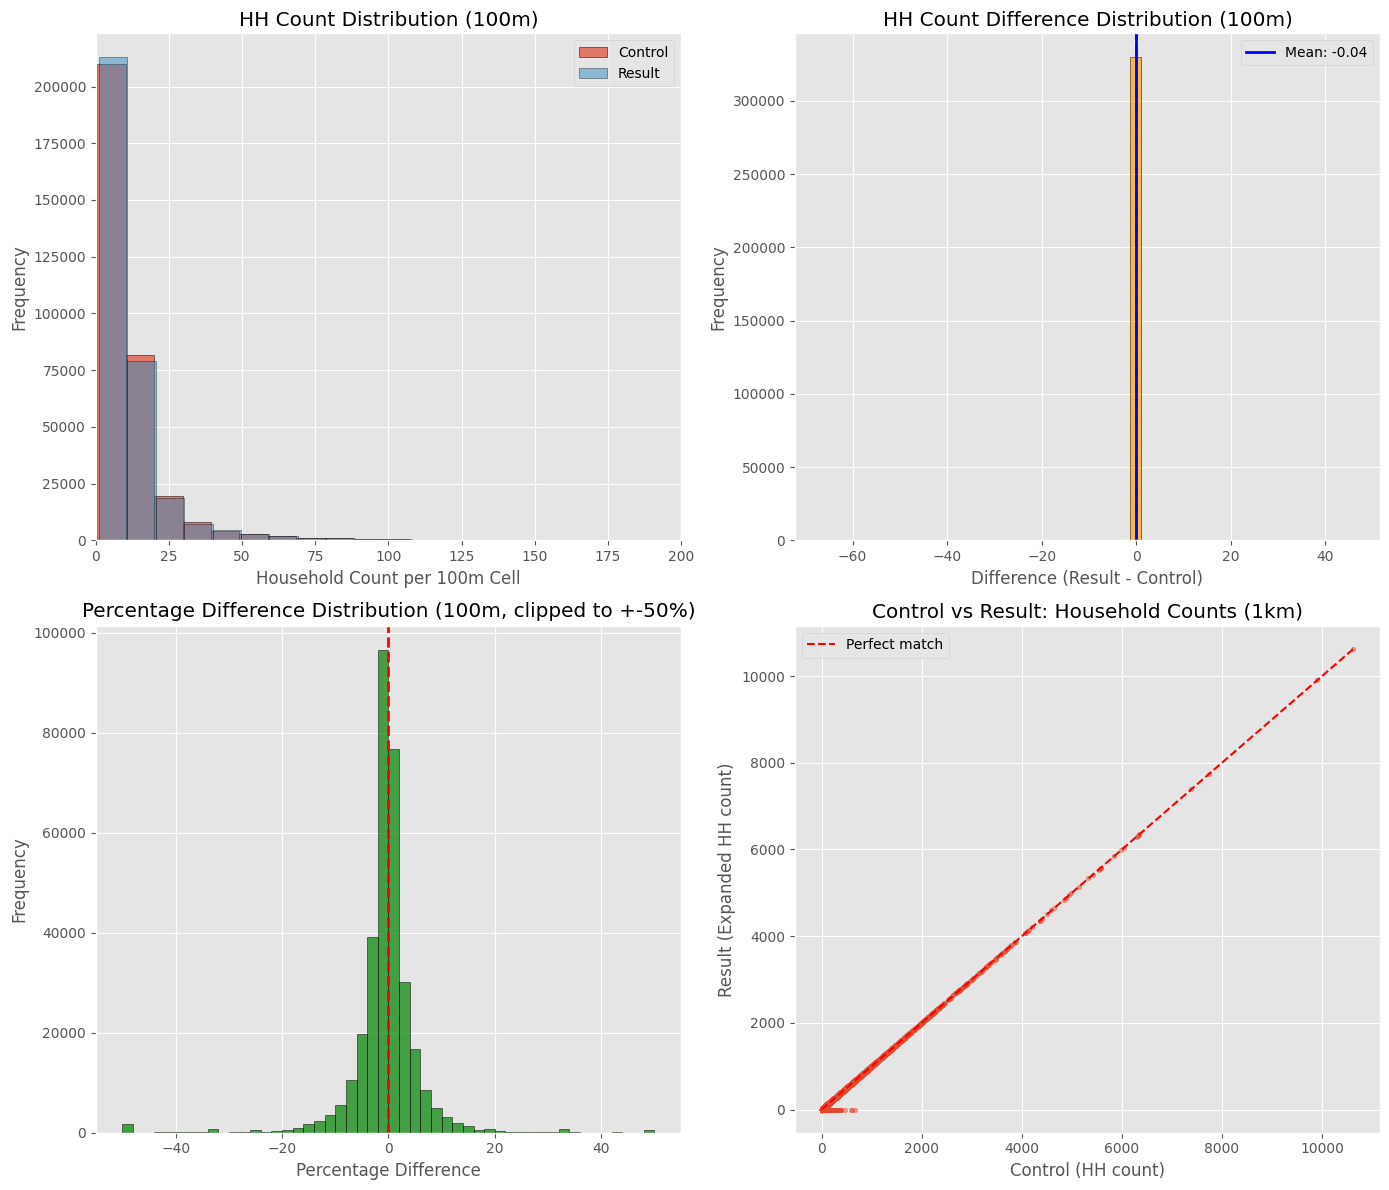

In [20]:
# Create summary plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. HH count distribution (100m)
ax1 = axes[0, 0]
ax1.hist(validation_100m[validation_100m[hh_control_col] > 0][hh_control_col], 
         bins=50, alpha=0.7, label='Control', edgecolor='black')
ax1.hist(validation_100m[validation_100m['hh_count'] > 0]['hh_count'], 
         bins=50, alpha=0.5, label='Result', edgecolor='black')
ax1.set_xlabel('Household Count per 100m Cell')
ax1.set_ylabel('Frequency')
ax1.set_title('HH Count Distribution (100m)')
ax1.legend()
ax1.set_xlim(0, 200)

# 2. Difference distribution
ax2 = axes[0, 1]
diff_data = validation_100m[validation_100m[hh_control_col] > 0]['diff']
ax2.hist(diff_data, bins=50, edgecolor='black', alpha=0.7, color='orange')
ax2.axvline(0, color='red', linestyle='--', linewidth=2)
ax2.axvline(diff_data.mean(), color='blue', linestyle='-', linewidth=2, label=f'Mean: {diff_data.mean():.2f}')
ax2.set_xlabel('Difference (Result - Control)')
ax2.set_ylabel('Frequency')
ax2.set_title('HH Count Difference Distribution (100m)')
ax2.legend()

# 3. Percentage difference distribution
ax3 = axes[1, 0]
pct_diff_data = validation_100m[validation_100m[hh_control_col] > 0]['pct_diff'].dropna()
pct_diff_clipped = pct_diff_data.clip(-50, 50)
ax3.hist(pct_diff_clipped, bins=50, edgecolor='black', alpha=0.7, color='green')
ax3.axvline(0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Percentage Difference')
ax3.set_ylabel('Frequency')
ax3.set_title('Percentage Difference Distribution (100m, clipped to +-50%)')

# 4. 1km level comparison
ax4 = axes[1, 1]
ax4.scatter(validation_1km[hh_control_col_1km], validation_1km['hh_count'], alpha=0.5, s=10)
max_val_1km = max(validation_1km[hh_control_col_1km].max(), validation_1km['hh_count'].max())
ax4.plot([0, max_val_1km], [0, max_val_1km], 'r--', label='Perfect match')
ax4.set_xlabel('Control (HH count)')
ax4.set_ylabel('Result (Expanded HH count)')
ax4.set_title('Control vs Result: Household Counts (1km)')
ax4.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'validation_summary.png')
plt.show()

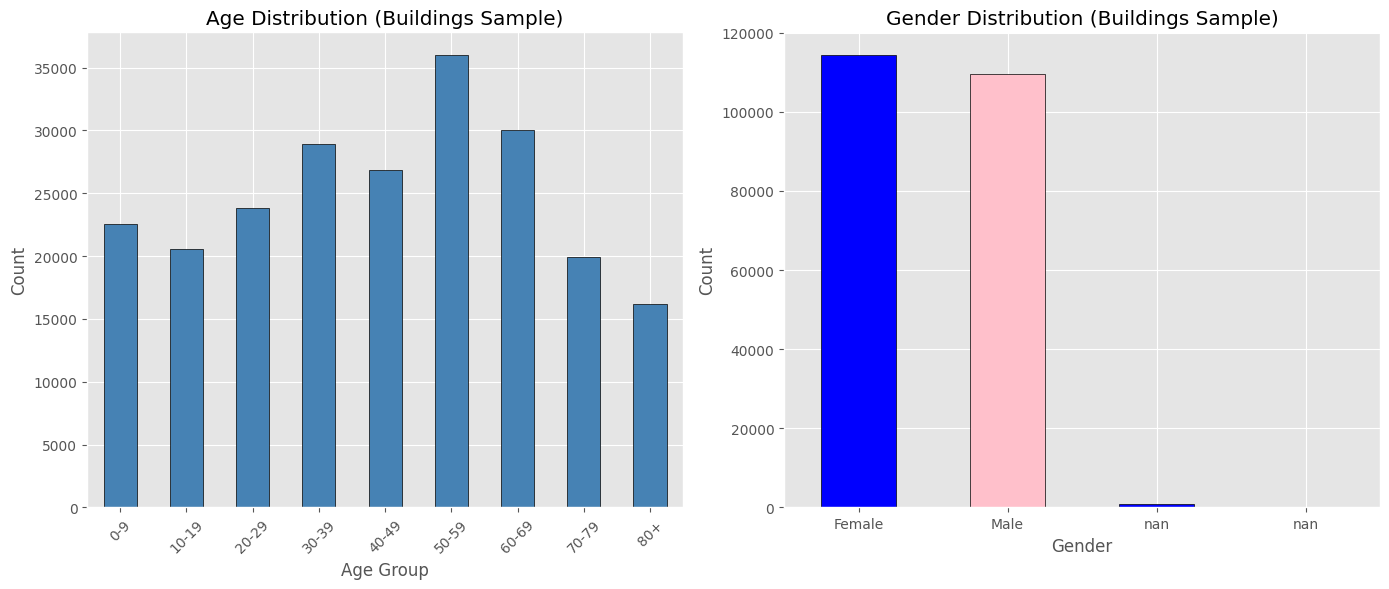

In [21]:
# Age-Sex distribution plot (if data available)
if 'persons_sample' in dir() and persons_sample is not None and len(persons_sample) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Age distribution
    ax1 = axes[0]
    age_counts = persons_sample['age_group'].value_counts().sort_index()
    age_counts.plot(kind='bar', ax=ax1, color='steelblue', edgecolor='black')
    ax1.set_xlabel('Age Group')
    ax1.set_ylabel('Count')
    ax1.set_title('Age Distribution (Buildings Sample)')
    ax1.tick_params(axis='x', rotation=45)
    
    # Gender distribution
    ax2 = axes[1]
    sex_counts = persons_sample['HP_SEX'].value_counts()
    sex_labels = {1: 'Male', 2: 'Female'}
    sex_counts.index = sex_counts.index.map(sex_labels)
    sex_counts.plot(kind='bar', ax=ax2, color=['blue', 'pink'], edgecolor='black')
    ax2.set_xlabel('Gender')
    ax2.set_ylabel('Count')
    ax2.set_title('Gender Distribution (Buildings Sample)')
    ax2.tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'age_sex_distribution.png')
    plt.show()

## 11. Detailed Cell-Level Validation

Validate a sample of cells in detail.

In [22]:
def validate_single_cell(cell_id, ctrl_100m, expanded_hh, gpkg_path=None):
    """Validate a single 100m cell in detail."""
    result = {'cell_id': cell_id}
    
    # Control data
    ctrl_row = ctrl_100m[ctrl_100m['ZENSUS100m'] == cell_id]
    if len(ctrl_row) == 0:
        result['status'] = 'NOT_IN_CONTROLS'
        return result
    
    ctrl_row = ctrl_row.iloc[0]
    result['ctrl_hh'] = ctrl_row.get(hh_control_col, 0)
    result['ctrl_pop'] = ctrl_row.get('POP_TOTAL_100m_adj_ZENSUS100m', 0)
    result['ctrl_m'] = ctrl_row.get('M_TOTAL_ZENSUS100m', 0)
    result['ctrl_f'] = ctrl_row.get('F_TOTAL_ZENSUS100m', 0)
    
    # Expanded HH data
    exp_cell = expanded_hh[expanded_hh['ZENSUS100m'] == cell_id]
    result['exp_hh'] = len(exp_cell)
    result['exp_unique_hh'] = exp_cell['H_ID'].nunique()
    
    # Differences
    result['diff_hh'] = result['exp_hh'] - result['ctrl_hh']
    result['status'] = 'OK' if abs(result['diff_hh']) <= 1 else 'DIFF'
    
    return result

# Validate a sample of cells
sample_cells = validation_100m.sample(min(100, len(validation_100m)))['ZENSUS100m'].tolist()

cell_validations = []
for cell_id in sample_cells:
    result = validate_single_cell(cell_id, ctrl_100m, expanded_hh)
    cell_validations.append(result)

cell_val_df = pd.DataFrame(cell_validations)
print(f"Sample cell validation results:")
print(cell_val_df['status'].value_counts())
print(f"\nSample with differences:")
print(cell_val_df[cell_val_df['status'] == 'DIFF'].head(10))

Sample cell validation results:
status
OK    100
Name: count, dtype: int64

Sample with differences:
Empty DataFrame
Columns: [cell_id, ctrl_hh, ctrl_pop, ctrl_m, ctrl_f, exp_hh, exp_unique_hh, diff_hh, status]
Index: []


## 12. Summary Statistics

In [23]:
# Compile summary statistics
summary_stats = {
    'Control Totals': {
        '100m cells': len(ctrl_100m),
        '1km cells': len(ctrl_1km),
        'Total HH (100m)': ctrl_100m[hh_control_col].sum(),
        'Total HH (1km)': ctrl_1km[hh_control_col_1km].sum(),
    },
    'Expanded HH': {
        'Total rows': len(expanded_hh),
        'Unique H_IDs': expanded_hh['H_ID'].nunique(),
        'Unique 100m cells': expanded_hh['ZENSUS100m'].nunique(),
        'Unique 1km cells': expanded_hh['ZENSUS1km'].nunique(),
    },
    'Validation (100m)': {
        'Total diff': validation_100m['diff'].sum(),
        'Mean diff': validation_100m['diff'].mean(),
        'Std diff': validation_100m['diff'].std(),
        'Max diff': validation_100m['diff'].max(),
        'Min diff': validation_100m['diff'].min(),
        'Pct diff': validation_100m['diff'].sum() / validation_100m[hh_control_col].sum() * 100,
    },
    'Validation (1km)': {
        'Total diff': validation_1km['diff'].sum(),
        'Mean diff': validation_1km['diff'].mean(),
        'Std diff': validation_1km['diff'].std(),
        'Pct diff': validation_1km['diff'].sum() / validation_1km[hh_control_col_1km].sum() * 100,
    },
}

if wege_available:
    summary_stats['Wege Data'] = {
        'Total trips': total_trips,
        'Unique H_IDs': len(hids_wege),
        'Unique persons': len(all_hpids),
        'H_IDs in common with expanded': len(hids_common),
    }

print("="*80)
print("VALIDATION SUMMARY")
print("="*80)

for section, stats in summary_stats.items():
    print(f"\n{section}:")
    for key, value in stats.items():
        if isinstance(value, float):
            print(f"  {key}: {value:,.2f}")
        else:
            print(f"  {key}: {value:,}")

VALIDATION SUMMARY

Control Totals:
  100m cells: 425,907
  1km cells: 30,146
  Total HH (100m): 3,816,448.32
  Total HH (1km): 3,816,448.32

Expanded HH:
  Total rows: 3,803,578
  Unique H_IDs: 130,068
  Unique 100m cells: 329,837
  Unique 1km cells: 27,710

Validation (100m):
  Total diff: -12,870.32
  Mean diff: -0.03
  Std diff: 0.71
  Max diff: 45.99
  Min diff: -66.57
  Pct diff: -0.34

Validation (1km):
  Total diff: -12,870.32
  Mean diff: -0.43
  Std diff: 10.82
  Pct diff: -0.34

Wege Data:
  Total trips: 655,073
  Unique H_IDs: 104,146
  Unique persons: 176,115
  H_IDs in common with expanded: 104,146


In [24]:
# Save summary to CSV
summary_rows = []
for section, stats in summary_stats.items():
    for key, value in stats.items():
        summary_rows.append({'Section': section, 'Metric': key, 'Value': value})

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv(OUTPUT_DIR / 'validation_summary.csv', index=False)
print(f"\nSummary saved to {OUTPUT_DIR / 'validation_summary.csv'}")


Summary saved to ../validation_results/validation_summary.csv


In [25]:
# Final validation status
print("\n" + "="*80)
print("FINAL VALIDATION STATUS")
print("="*80)

issues = []

# Check HH totals
hh_pct_diff = abs(validation_100m['diff'].sum() / validation_100m[hh_control_col].sum() * 100)
if hh_pct_diff > 1:
    issues.append(f"HH total difference > 1%: {hh_pct_diff:.2f}%")

# Check cell consistency
if len(cells_missing_hh) > 0:
    issues.append(f"{len(cells_missing_hh)} cells with HH control > 0 but no expanded HH")

# Check H_ID consistency
if wege_available and len(hids_only_wege) > 0:
    issues.append(f"{len(hids_only_wege)} H_IDs in wege not in expanded HH")

if issues:
    print("\nISSUES FOUND:")
    for issue in issues:
        print(f"  - {issue}")
else:
    print("\nNO MAJOR ISSUES FOUND")

print(f"\nOverall HH matching: {100 - hh_pct_diff:.2f}%")


FINAL VALIDATION STATUS

ISSUES FOUND:
  - 1772 cells with HH control > 0 but no expanded HH

Overall HH matching: 99.66%


## 13. Per-Control Difference Distributions

Generate difference distribution plots for ALL control values at each geography level, similar to the original PopSim validation script.

In [26]:
def process_control(control_df, control_col, result_col, name, geography):
    """
    Process a single control comparison and return statistics and difference series.
    
    Parameters
    ----------
    control_df : DataFrame with control and result columns
    control_col : str, control column name
    result_col : str, result column name  
    name : str, output plot title
    geography : str, geography level
    
    Returns
    -------
    stats : pandas Series of statistics
    difference : pandas Series of differences (result - control)
    """
    sub_df = control_df[[control_col, result_col]].dropna(axis=0, how='any')
    
    observed = sub_df[control_col]
    non_zero_observed = observed[observed > 0]
    predicted = sub_df[result_col]
    difference = predicted - observed
    
    # Only compute percentage diff for non-zero observed
    non_zero_mask = observed > 0
    pc_difference = np.where(non_zero_mask, (difference / observed) * 100, 0)
    pc_difference_nonzero = pc_difference[non_zero_mask]
    
    rmse = (difference ** 2).mean() ** 0.5
    
    stats = pd.Series({
        'name': name,
        'geography': geography,
        'observed': observed.sum(),
        'predicted': predicted.sum(),
        'difference': difference.sum(),
        'pc_difference': (difference.sum() / max(observed.sum(), 1)) * 100,
        'mean_pc_difference': pc_difference_nonzero.mean() if len(pc_difference_nonzero) > 0 else 0,
        'N': len(non_zero_observed),
        'rmse': rmse,
        'std': pc_difference_nonzero.std() if len(pc_difference_nonzero) > 0 else 0,
    })
    
    return stats, difference

print("Control processing function defined.")

Control processing function defined.


In [27]:
# Build validation dataframe for 100m level
# Merge expanded HH counts with control totals

# Get HH counts per cell
hh_counts_100m = expanded_hh.groupby('ZENSUS100m').size().reset_index(name='hh_result')

# Merge with controls
val_100m = ctrl_100m.merge(hh_counts_100m, on='ZENSUS100m', how='left').fillna(0)

# Add result columns for each control (using expanded HH data)
# For HH control, we already have hh_result
# For person controls, we need person-level data from buildings

# Define control mappings for 100m level
control_mappings_100m = []

# HH total
hh_ctrl_100m = 'Insgesamt_Haushalte_Groesse_des_privaten_Haushalts_100m_Gitter_adj_ZENSUS100m'
control_mappings_100m.append({
    'name': 'HH Total',
    'geography': 'ZENSUS100m',
    'control_col': hh_ctrl_100m,
    'result_col': 'hh_result'
})

print(f"Validation dataframe built: {len(val_100m):,} cells")
print(f"Control mappings defined: {len(control_mappings_100m)} controls")

Validation dataframe built: 425,907 cells
Control mappings defined: 1 controls


In [28]:
# Parse ALL MiD data from buildings to get full person-level data by cell
# This is needed to compare person controls

def parse_all_mid_data_by_cell(gpkg_path, batch_size=100000):
    """Parse MiD data from buildings and aggregate by cell."""
    import subprocess
    import io
    import json
    
    # Get all cells with mid_data
    sql = """
    SELECT cell_id, mid_data 
    FROM buildings_with_mid_data 
    WHERE mid_data IS NOT NULL AND mid_data != ''
    """
    
    print("Querying buildings with MiD data (this may take a while)...")
    result = subprocess.run(
        ['ogr2ogr', '-f', 'CSV', '/vsistdout/', str(gpkg_path), '-sql', sql],
        capture_output=True, text=True, timeout=600
    )
    
    if result.returncode != 0:
        print(f"Error: {result.stderr[:500]}")
        return None
    
    df = pd.read_csv(io.StringIO(result.stdout))
    print(f"Processing {len(df):,} buildings with MiD data...")
    
    # Aggregate by cell
    cell_agg = defaultdict(lambda: {
        'hh_count': 0, 'pop_total': 0,
        'm_total': 0, 'f_total': 0,
        'm_0_9': 0, 'm_10_19': 0, 'm_20_29': 0, 'm_30_39': 0, 'm_40_49': 0,
        'm_50_59': 0, 'm_60_69': 0, 'm_70_79': 0, 'm_80_plus': 0,
        'f_0_9': 0, 'f_10_19': 0, 'f_20_29': 0, 'f_30_39': 0, 'f_40_49': 0,
        'f_50_59': 0, 'f_60_69': 0, 'f_70_79': 0, 'f_80_plus': 0,
    })
    
    def get_age_bin(age):
        if age < 10: return '0_9'
        elif age < 20: return '10_19'
        elif age < 30: return '20_29'
        elif age < 40: return '30_39'
        elif age < 50: return '40_49'
        elif age < 60: return '50_59'
        elif age < 70: return '60_69'
        elif age < 80: return '70_79'
        else: return '80_plus'
    
    for idx, row in df.iterrows():
        if idx % 50000 == 0:
            print(f"  Processed {idx:,} / {len(df):,} buildings...")
        
        if pd.isna(row['mid_data']) or not row['mid_data'].strip():
            continue
        
        cell_id = row['cell_id']
        try:
            mid_data = json.loads(row['mid_data'].replace('""', '"'))
            for hh in mid_data:
                cell_agg[cell_id]['hh_count'] += 1
                for p in hh.get('persons', []):
                    cell_agg[cell_id]['pop_total'] += 1
                    sex = p.get('HP_SEX', 0)
                    age = p.get('HP_ALTER', 0)
                    age_bin = get_age_bin(age)
                    
                    if sex == 1:  # Male
                        cell_agg[cell_id]['m_total'] += 1
                        cell_agg[cell_id][f'm_{age_bin}'] += 1
                    elif sex == 2:  # Female
                        cell_agg[cell_id]['f_total'] += 1
                        cell_agg[cell_id][f'f_{age_bin}'] += 1
        except (json.JSONDecodeError, KeyError):
            continue
    
    print(f"Aggregation complete: {len(cell_agg):,} cells")
    return pd.DataFrame.from_dict(cell_agg, orient='index').reset_index().rename(columns={'index': 'ZENSUS100m'})

if BUILDINGS_GPKG.exists():
    buildings_by_cell_detailed = parse_all_mid_data_by_cell(BUILDINGS_GPKG)
else:
    buildings_by_cell_detailed = None
    print("Buildings GPKG not found, skipping person-level aggregation.")

Querying buildings with MiD data (this may take a while)...
Processing 2,103,031 buildings with MiD data...
  Processed 0 / 2,103,031 buildings...
  Processed 50,000 / 2,103,031 buildings...
  Processed 100,000 / 2,103,031 buildings...
  Processed 150,000 / 2,103,031 buildings...
  Processed 200,000 / 2,103,031 buildings...
  Processed 250,000 / 2,103,031 buildings...
  Processed 300,000 / 2,103,031 buildings...
  Processed 350,000 / 2,103,031 buildings...
  Processed 400,000 / 2,103,031 buildings...
  Processed 450,000 / 2,103,031 buildings...
  Processed 500,000 / 2,103,031 buildings...
  Processed 550,000 / 2,103,031 buildings...
  Processed 600,000 / 2,103,031 buildings...
  Processed 650,000 / 2,103,031 buildings...
  Processed 700,000 / 2,103,031 buildings...
  Processed 750,000 / 2,103,031 buildings...
  Processed 800,000 / 2,103,031 buildings...
  Processed 850,000 / 2,103,031 buildings...
  Processed 900,000 / 2,103,031 buildings...
  Processed 950,000 / 2,103,031 buildings...

In [29]:
# Build full validation dataframe with all control results
if buildings_by_cell_detailed is not None:
    # Merge buildings aggregation with controls
    val_100m_full = ctrl_100m.merge(buildings_by_cell_detailed, on='ZENSUS100m', how='left').fillna(0)
    
    # Define all control mappings
    all_control_mappings = [
        {'name': 'HH Total', 'control_col': hh_control_col, 'result_col': 'hh_count'},
        {'name': 'Population Total', 'control_col': 'POP_TOTAL_100m_adj_ZENSUS100m', 'result_col': 'pop_total'},
        {'name': 'Male Total', 'control_col': 'M_TOTAL_ZENSUS100m', 'result_col': 'm_total'},
        {'name': 'Female Total', 'control_col': 'F_TOTAL_ZENSUS100m', 'result_col': 'f_total'},
    ]
    
    # Add age-sex controls
    for age_bin in AGE_LABELS:
        all_control_mappings.append({
            'name': f'Male {age_bin}',
            'control_col': f'M_AGE_{age_bin}_agg_ZENSUS100m',
            'result_col': f'm_{age_bin}'
        })
        all_control_mappings.append({
            'name': f'Female {age_bin}',
            'control_col': f'F_AGE_{age_bin}_agg_ZENSUS100m',
            'result_col': f'f_{age_bin}'
        })
    
    print(f"Full validation data: {len(val_100m_full):,} cells")
    print(f"Control mappings defined: {len(all_control_mappings)} controls")
else:
    val_100m_full = val_100m
    all_control_mappings = control_mappings_100m
    print("Using HH-only validation (buildings data not available)")

Full validation data: 425,907 cells
Control mappings defined: 22 controls


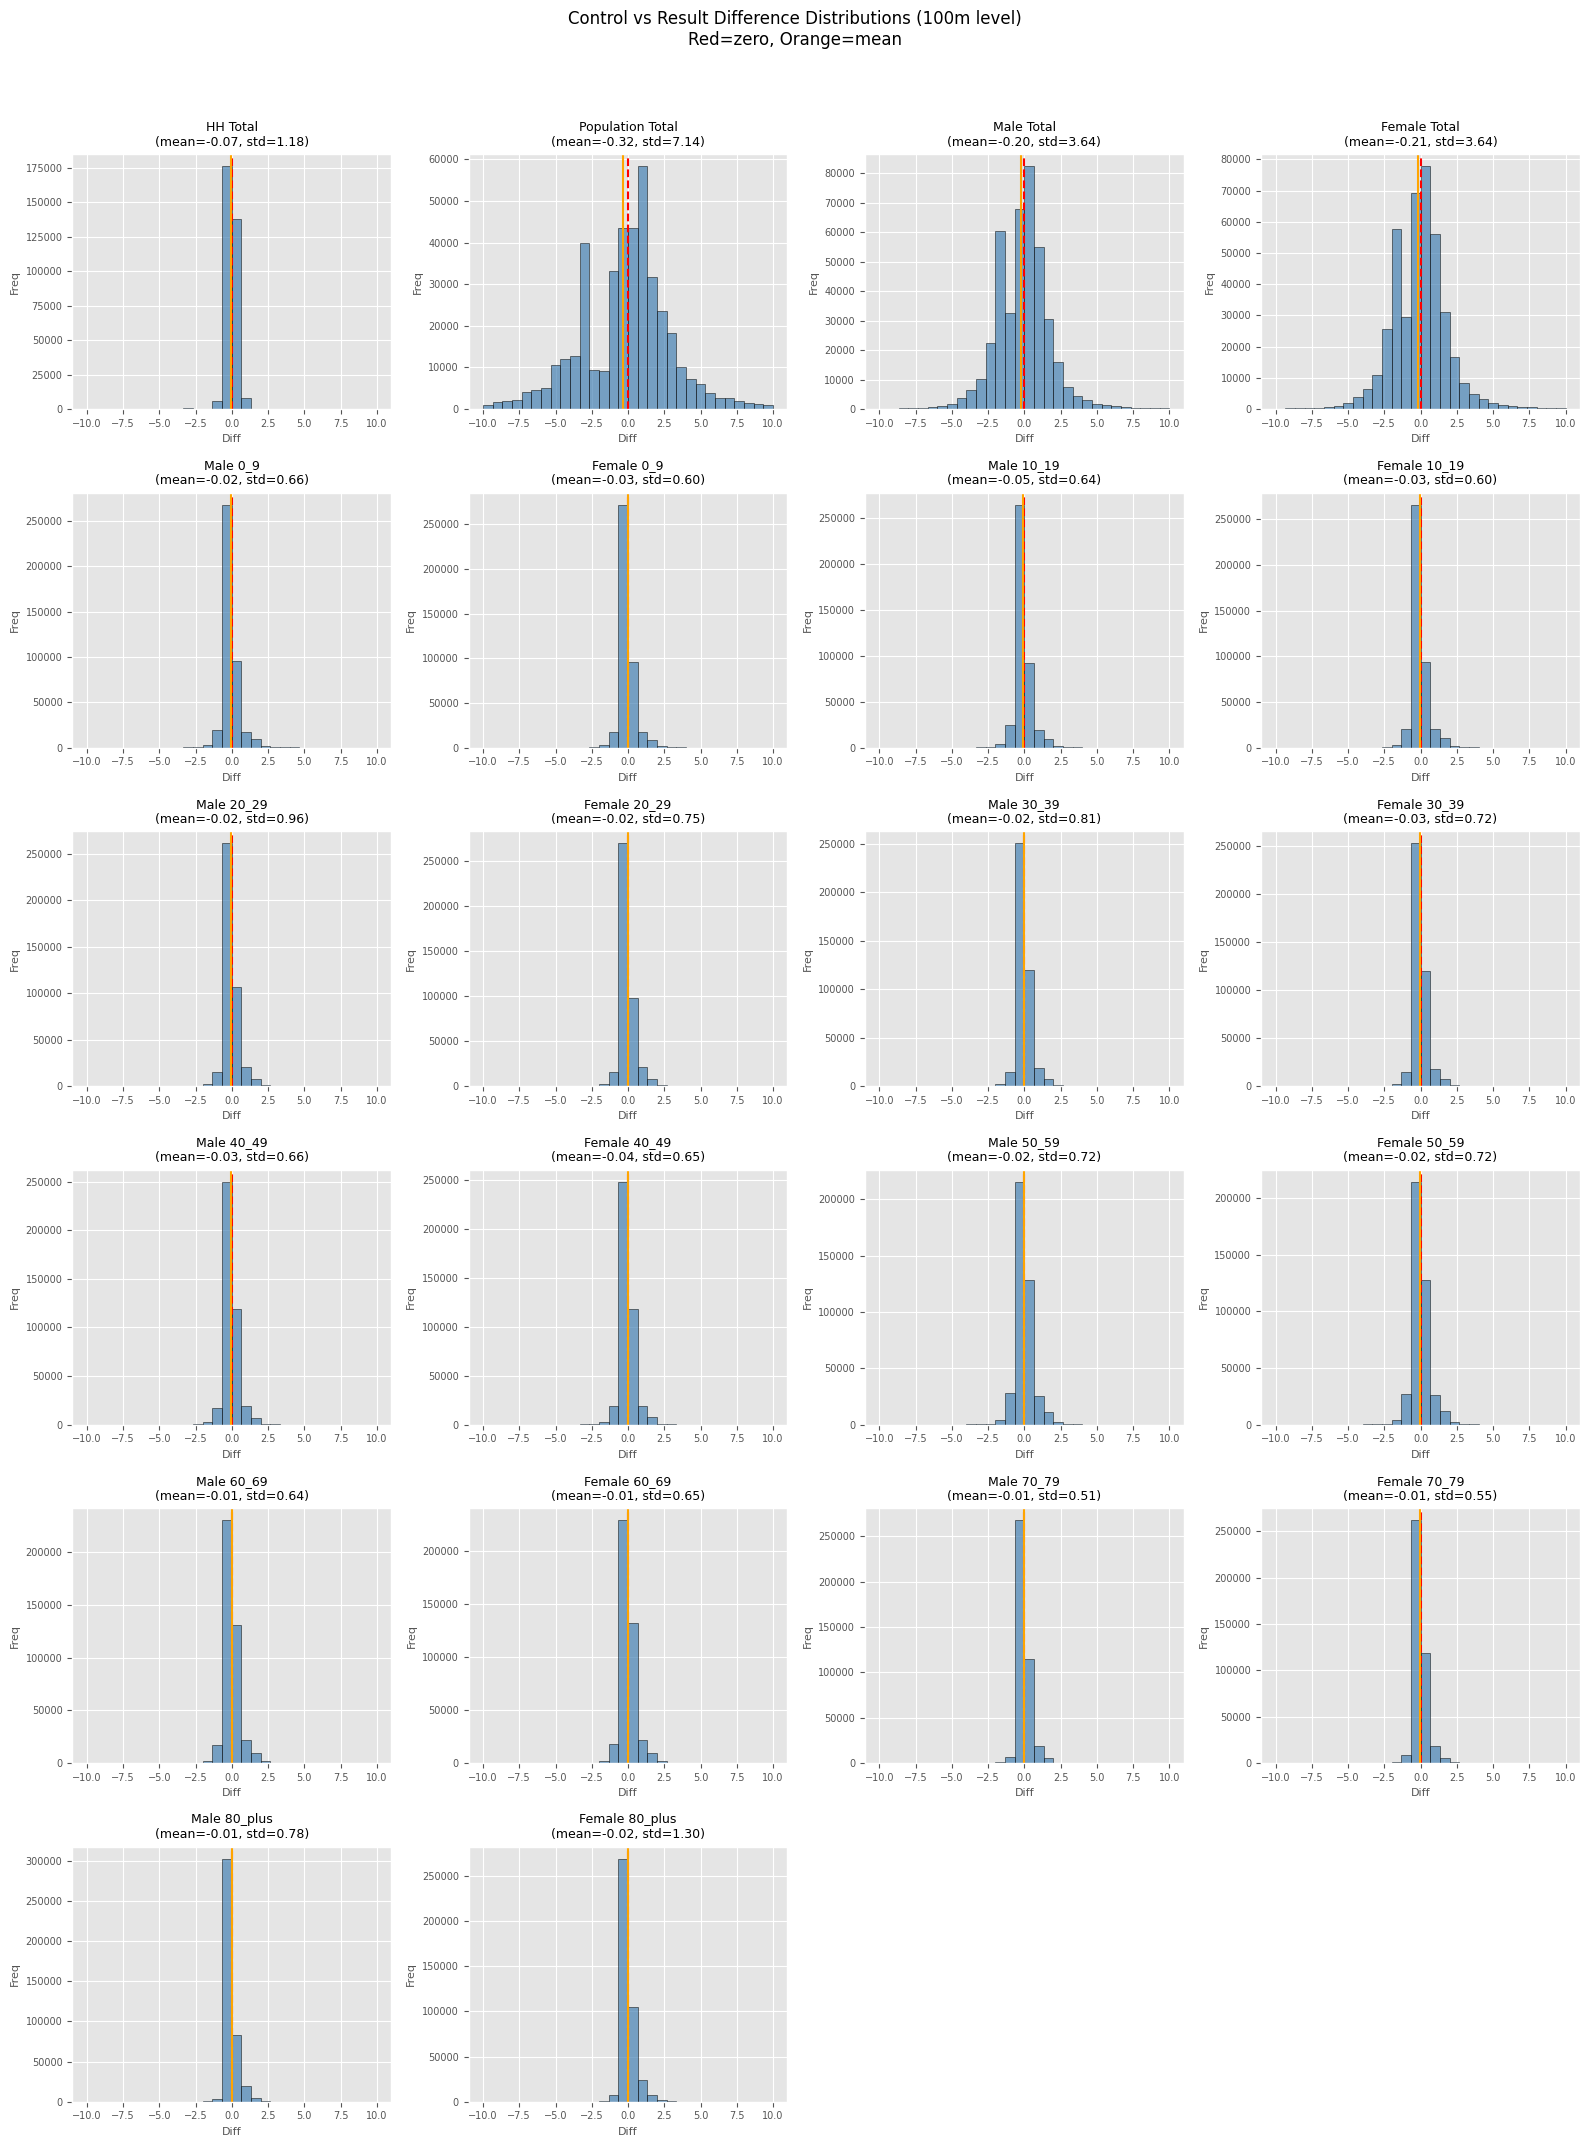


Statistics saved to ../validation_results/control_validation_stats_100m.csv


In [30]:
# Generate difference distribution plots for ALL controls (100m level)

# Calculate number of rows/cols for subplot grid
n_controls = len(all_control_mappings)
n_cols = 4
n_rows = (n_controls + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3.5))
axes = axes.flatten()

# Process each control and create histogram
all_stats = []

for i, mapping in enumerate(all_control_mappings):
    ax = axes[i]
    name = mapping['name']
    ctrl_col = mapping['control_col']
    res_col = mapping['result_col']
    
    # Check if columns exist
    if ctrl_col not in val_100m_full.columns:
        ax.text(0.5, 0.5, f'{name}\n(Control column missing)', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(name, fontsize=9)
        continue
    if res_col not in val_100m_full.columns:
        ax.text(0.5, 0.5, f'{name}\n(Result column missing)', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(name, fontsize=9)
        continue
    
    # Get statistics
    stats, diff = process_control(val_100m_full, ctrl_col, res_col, name, 'ZENSUS100m')
    all_stats.append(stats)
    
    # Filter to cells with non-zero control values
    mask = val_100m_full[ctrl_col] > 0
    diff_filtered = diff[mask]
    
    # Plot histogram
    ax.hist(diff_filtered, bins=30, range=(-10, 10), alpha=0.7, edgecolor='black', color='steelblue')
    ax.axvline(0, color='red', linestyle='--', linewidth=1.5)
    ax.axvline(diff_filtered.mean(), color='orange', linestyle='-', linewidth=1.5)
    ax.set_xlabel('Diff', fontsize=8)
    ax.set_ylabel('Freq', fontsize=8)
    ax.set_title(f'{name}\n(mean={diff_filtered.mean():.2f}, std={diff_filtered.std():.2f})', fontsize=9)
    ax.tick_params(axis='both', which='major', labelsize=7)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Control vs Result Difference Distributions (100m level)\nRed=zero, Orange=mean', fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'control_difference_distributions_100m.png', bbox_inches='tight', dpi=150)
plt.show()

# Save statistics to CSV
stats_df = pd.DataFrame(all_stats)
stats_df.to_csv(OUTPUT_DIR / 'control_validation_stats_100m.csv', index=False)
print(f"\nStatistics saved to {OUTPUT_DIR / 'control_validation_stats_100m.csv'}")

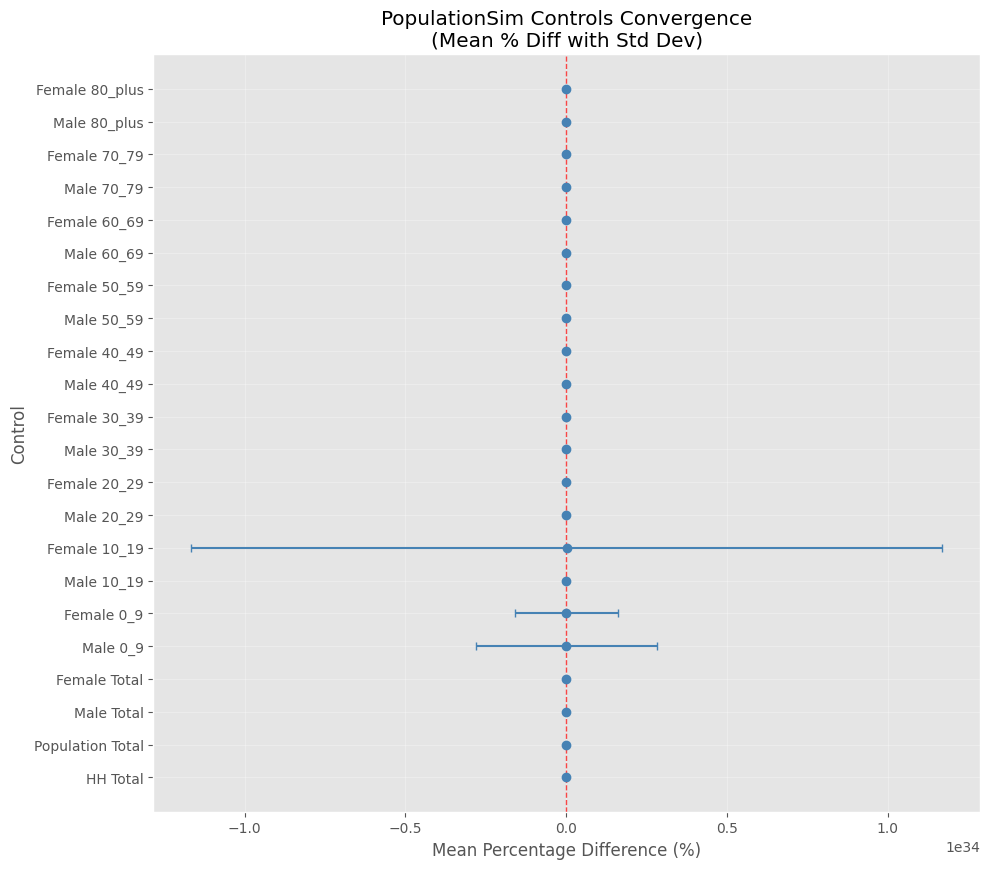

In [31]:
# Convergence plot: Mean percentage difference with standard deviation error bars
if len(all_stats) > 0:
    fig, ax = plt.subplots(figsize=(10, max(8, len(all_stats) * 0.4)))
    
    ax.errorbar(
        stats_df['mean_pc_difference'],
        stats_df['name'],
        xerr=stats_df['std'],
        linestyle='None',
        marker='o',
        markersize=6,
        capsize=3,
        color='steelblue'
    )
    
    ax.axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)
    ax.set_xlabel('Mean Percentage Difference (%)')
    ax.set_ylabel('Control')
    ax.set_title('PopulationSim Controls Convergence\n(Mean % Diff with Std Dev)')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'control_convergence_stdev.png', bbox_inches='tight', dpi=150)
    plt.show()
else:
    print("No statistics available for convergence plot.")

In [32]:
# 1km level validation
# Aggregate buildings data to 1km level using geo crosswalk

if buildings_by_cell_detailed is not None:
    # Merge with geo crosswalk to get 1km cell
    buildings_with_1km = buildings_by_cell_detailed.merge(
        geo_xwalk[['ZENSUS100m', 'ZENSUS1km']], 
        on='ZENSUS100m', 
        how='left'
    )
    
    # Aggregate to 1km
    agg_cols = [c for c in buildings_by_cell_detailed.columns if c != 'ZENSUS100m']
    buildings_1km = buildings_with_1km.groupby('ZENSUS1km')[agg_cols].sum().reset_index()
    
    # Merge with 1km controls
    val_1km_full = ctrl_1km.merge(buildings_1km, on='ZENSUS1km', how='left').fillna(0)
    
    # Define 1km control mappings
    hh_ctrl_1km = 'Insgesamt_Haushalte_Groesse_des_privaten_Haushalts_100m_Gitter_adj_ZENSUS1km'
    
    all_control_mappings_1km = [
        {'name': 'HH Total', 'control_col': hh_ctrl_1km, 'result_col': 'hh_count'},
        {'name': 'Population Total', 'control_col': 'POP_TOTAL_100m_adj_ZENSUS1km', 'result_col': 'pop_total'},
        {'name': 'Male Total', 'control_col': 'M_TOTAL_ZENSUS1km', 'result_col': 'm_total'},
        {'name': 'Female Total', 'control_col': 'F_TOTAL_ZENSUS1km', 'result_col': 'f_total'},
    ]
    
    for age_bin in AGE_LABELS:
        all_control_mappings_1km.append({
            'name': f'Male {age_bin}',
            'control_col': f'M_AGE_{age_bin}_agg_ZENSUS1km',
            'result_col': f'm_{age_bin}'
        })
        all_control_mappings_1km.append({
            'name': f'Female {age_bin}',
            'control_col': f'F_AGE_{age_bin}_agg_ZENSUS1km',
            'result_col': f'f_{age_bin}'
        })
    
    print(f"1km validation data: {len(val_1km_full):,} cells")
else:
    val_1km_full = None
    all_control_mappings_1km = []
    print("Buildings data not available for 1km validation")

1km validation data: 30,146 cells


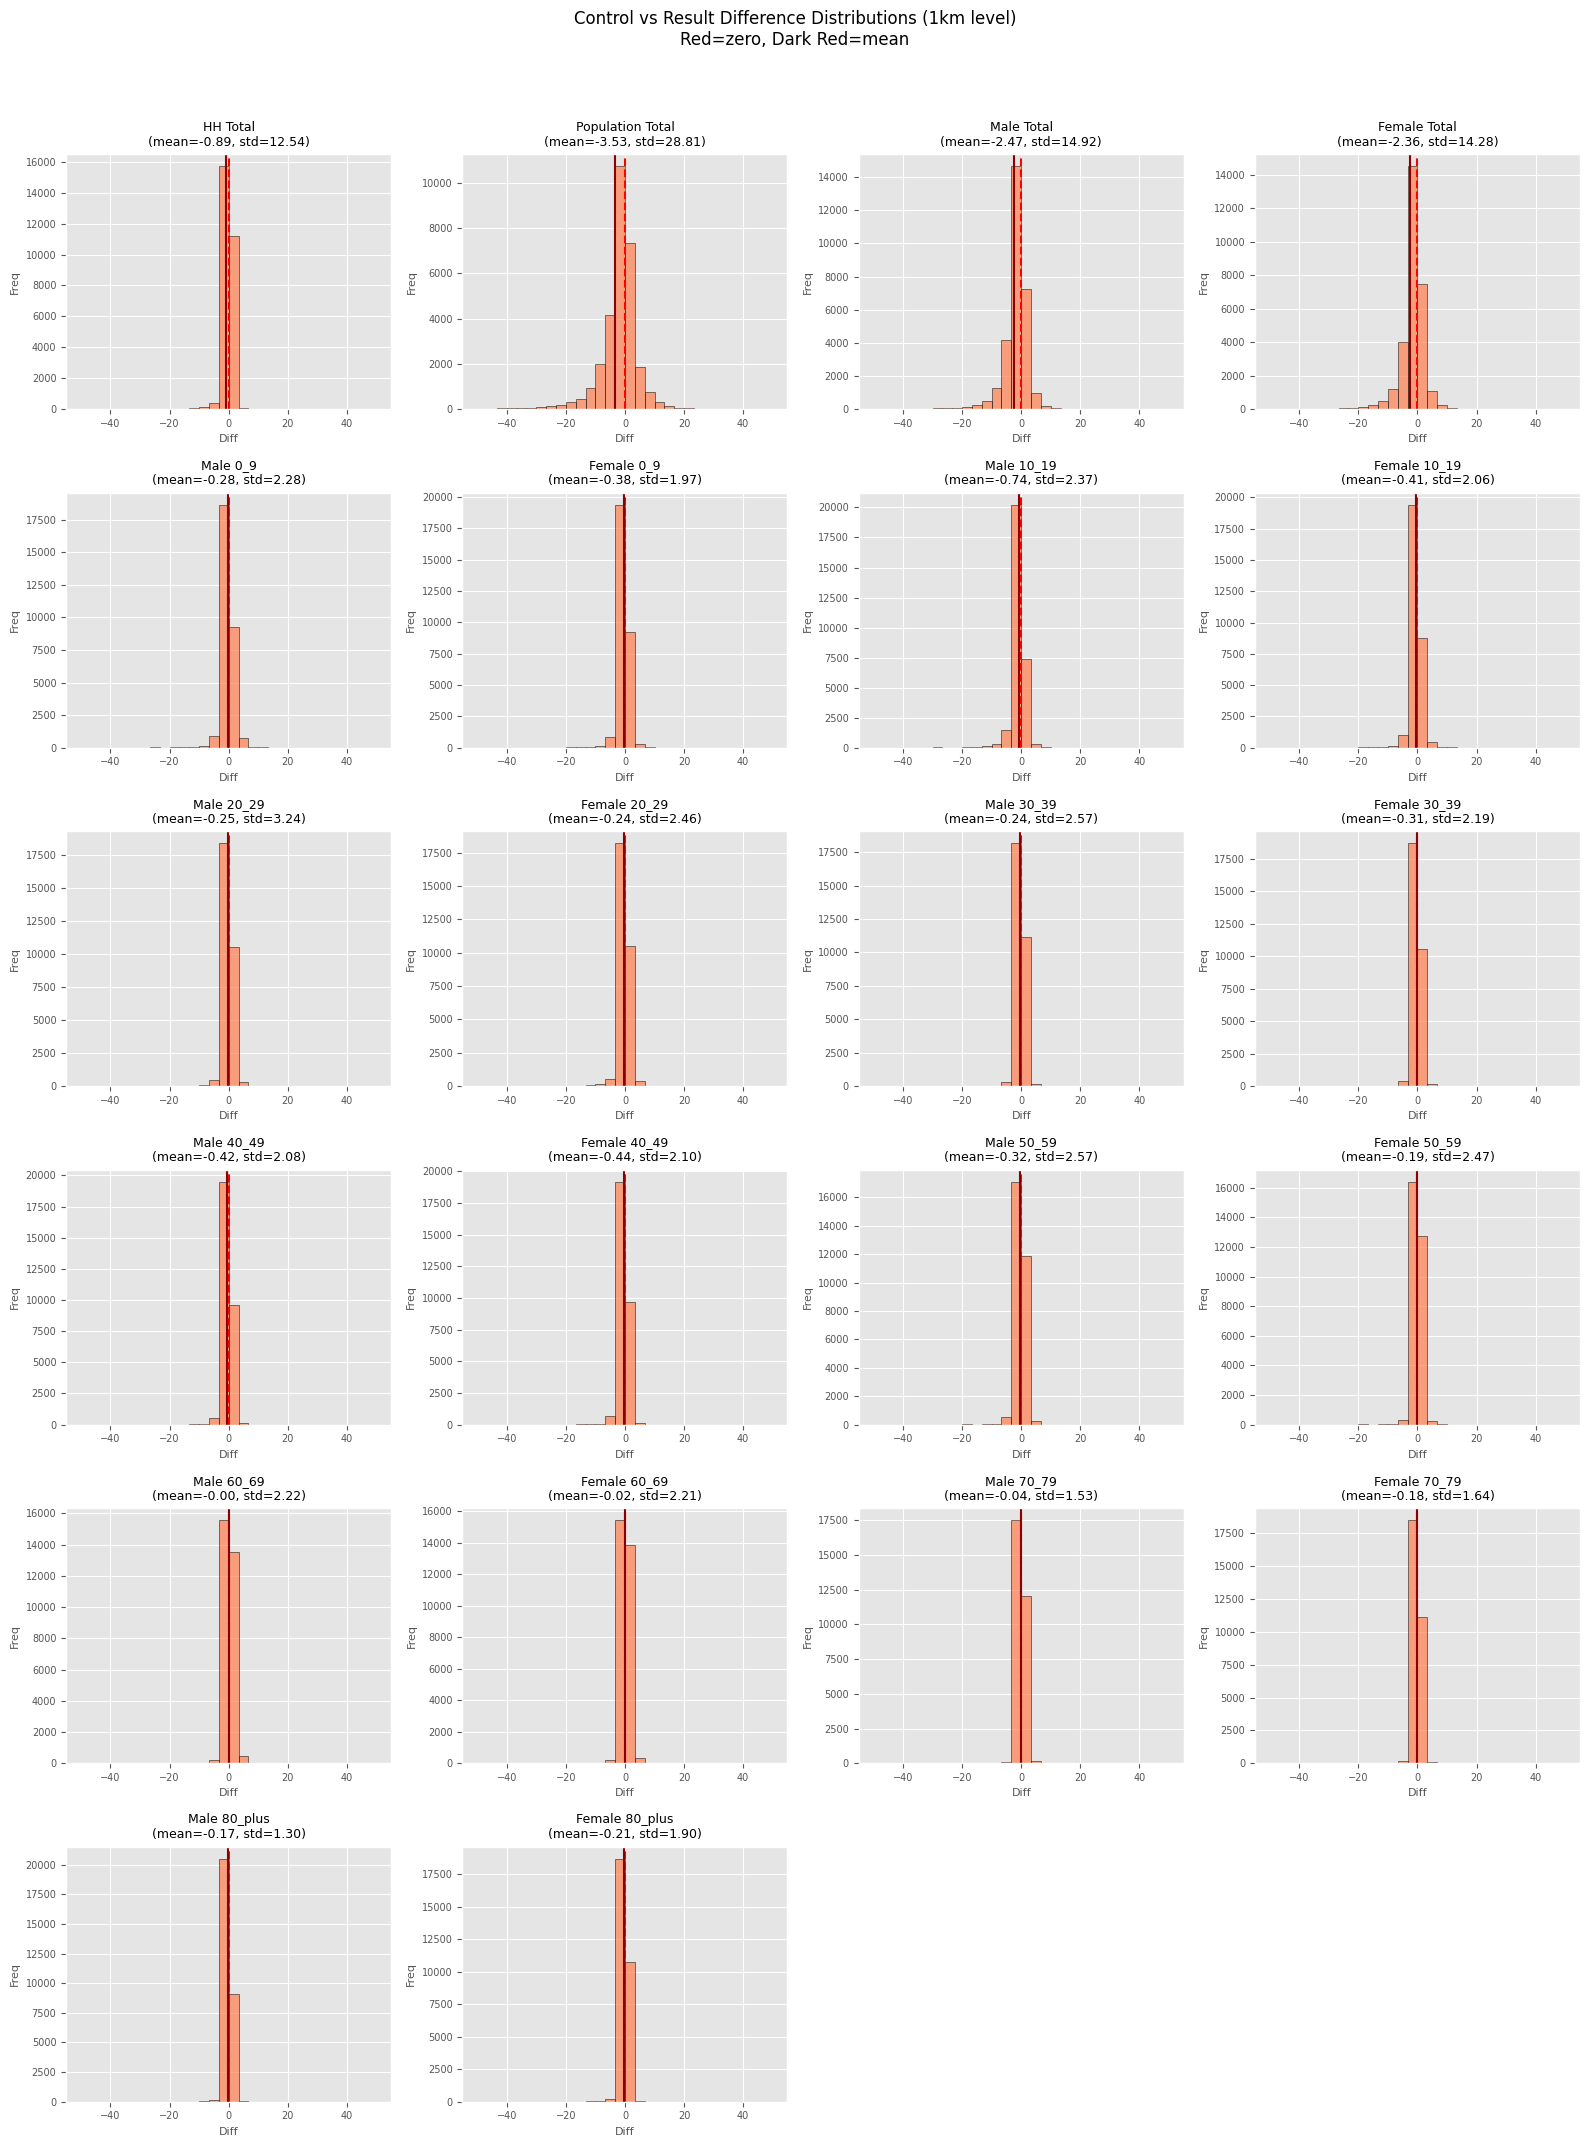


1km statistics saved to ../validation_results/control_validation_stats_1km.csv


In [33]:
# Generate difference distribution plots for ALL controls (1km level)
if val_1km_full is not None and len(all_control_mappings_1km) > 0:
    n_controls_1km = len(all_control_mappings_1km)
    n_cols_1km = 4
    n_rows_1km = (n_controls_1km + n_cols_1km - 1) // n_cols_1km

    fig, axes = plt.subplots(n_rows_1km, n_cols_1km, figsize=(n_cols_1km * 4, n_rows_1km * 3.5))
    axes = axes.flatten()

    all_stats_1km = []

    for i, mapping in enumerate(all_control_mappings_1km):
        ax = axes[i]
        name = mapping['name']
        ctrl_col = mapping['control_col']
        res_col = mapping['result_col']
        
        if ctrl_col not in val_1km_full.columns or res_col not in val_1km_full.columns:
            ax.text(0.5, 0.5, f'{name}\n(Column missing)', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(name, fontsize=9)
            continue
        
        stats, diff = process_control(val_1km_full, ctrl_col, res_col, name, 'ZENSUS1km')
        all_stats_1km.append(stats)
        
        mask = val_1km_full[ctrl_col] > 0
        diff_filtered = diff[mask]
        
        ax.hist(diff_filtered, bins=30, range=(-50, 50), alpha=0.7, edgecolor='black', color='coral')
        ax.axvline(0, color='red', linestyle='--', linewidth=1.5)
        ax.axvline(diff_filtered.mean(), color='darkred', linestyle='-', linewidth=1.5)
        ax.set_xlabel('Diff', fontsize=8)
        ax.set_ylabel('Freq', fontsize=8)
        ax.set_title(f'{name}\n(mean={diff_filtered.mean():.2f}, std={diff_filtered.std():.2f})', fontsize=9)
        ax.tick_params(axis='both', which='major', labelsize=7)

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle('Control vs Result Difference Distributions (1km level)\nRed=zero, Dark Red=mean', fontsize=12, y=1.02)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'control_difference_distributions_1km.png', bbox_inches='tight', dpi=150)
    plt.show()

    stats_df_1km = pd.DataFrame(all_stats_1km)
    stats_df_1km.to_csv(OUTPUT_DIR / 'control_validation_stats_1km.csv', index=False)
    print(f"\n1km statistics saved to {OUTPUT_DIR / 'control_validation_stats_1km.csv'}")
else:
    print("1km validation skipped (data not available)")

## 14. Cross-Dataset Comparisons

Compare age/gender distributions across datasets:
- Census control totals
- Buildings MiD data
- Wege persons data

In [34]:
# Compute aggregate distributions from each data source

# 1. Census controls (100m level)
census_totals = {
    'HH': ctrl_100m[hh_control_col].sum(),
    'POP': ctrl_100m['POP_TOTAL_100m_adj_ZENSUS100m'].sum(),
    'M': ctrl_100m['M_TOTAL_ZENSUS100m'].sum(),
    'F': ctrl_100m['F_TOTAL_ZENSUS100m'].sum(),
}

census_age_sex = {}
for age_bin in AGE_LABELS:
    census_age_sex[f'M_{age_bin}'] = ctrl_100m[f'M_AGE_{age_bin}_agg_ZENSUS100m'].sum()
    census_age_sex[f'F_{age_bin}'] = ctrl_100m[f'F_AGE_{age_bin}_agg_ZENSUS100m'].sum()

print("Census control totals (100m):")
print(f"  HH: {census_totals['HH']:,.0f}")
print(f"  Population: {census_totals['POP']:,.0f}")
print(f"  Male: {census_totals['M']:,.0f} ({census_totals['M']/census_totals['POP']*100:.1f}%)")
print(f"  Female: {census_totals['F']:,.0f} ({census_totals['F']/census_totals['POP']*100:.1f}%)")

Census control totals (100m):
  HH: 3,816,448
  Population: 7,952,562
  Male: 3,909,580 (49.2%)
  Female: 4,042,982 (50.8%)


In [35]:
# 2. Buildings MiD data totals
if buildings_by_cell_detailed is not None:
    buildings_totals = {
        'HH': buildings_by_cell_detailed['hh_count'].sum(),
        'POP': buildings_by_cell_detailed['pop_total'].sum(),
        'M': buildings_by_cell_detailed['m_total'].sum(),
        'F': buildings_by_cell_detailed['f_total'].sum(),
    }
    
    buildings_age_sex = {}
    for age_bin in AGE_LABELS:
        buildings_age_sex[f'M_{age_bin}'] = buildings_by_cell_detailed[f'm_{age_bin}'].sum()
        buildings_age_sex[f'F_{age_bin}'] = buildings_by_cell_detailed[f'f_{age_bin}'].sum()
    
    print("Buildings MiD data totals:")
    print(f"  HH: {buildings_totals['HH']:,.0f}")
    print(f"  Population: {buildings_totals['POP']:,.0f}")
    print(f"  Male: {buildings_totals['M']:,.0f} ({buildings_totals['M']/max(buildings_totals['POP'],1)*100:.1f}%)")
    print(f"  Female: {buildings_totals['F']:,.0f} ({buildings_totals['F']/max(buildings_totals['POP'],1)*100:.1f}%)")
else:
    buildings_totals = None
    buildings_age_sex = None
    print("Buildings data not available")

Buildings MiD data totals:
  HH: 3,791,761
  Population: 7,847,199
  Male: 3,835,943 (48.9%)
  Female: 3,972,450 (50.6%)


In [36]:
# 3. Wege persons data totals
if wege_available:
    wege_persons_unique = wege_persons
    
    wege_totals = {
        'HH': wege_persons_unique['H_ID'].nunique(),
        'POP': len(wege_persons_unique),
        'M': (wege_persons_unique['HP_SEX'] == 1).sum(),
        'F': (wege_persons_unique['HP_SEX'] == 2).sum(),
    }
    
    # Age-sex breakdown
    def get_age_bin_label(age):
        if age < 10: return '0_9'
        elif age < 20: return '10_19'
        elif age < 30: return '20_29'
        elif age < 40: return '30_39'
        elif age < 50: return '40_49'
        elif age < 60: return '50_59'
        elif age < 70: return '60_69'
        elif age < 80: return '70_79'
        else: return '80_plus'
    
    wege_persons_unique['age_bin'] = wege_persons_unique['HP_ALTER'].apply(get_age_bin_label)
    
    wege_age_sex = {}
    for age_bin in AGE_LABELS:
        wege_age_sex[f'M_{age_bin}'] = ((wege_persons_unique['HP_SEX'] == 1) & 
                                         (wege_persons_unique['age_bin'] == age_bin)).sum()
        wege_age_sex[f'F_{age_bin}'] = ((wege_persons_unique['HP_SEX'] == 2) & 
                                         (wege_persons_unique['age_bin'] == age_bin)).sum()
    
    print("Wege persons data totals:")
    print(f"  HH: {wege_totals['HH']:,.0f}")
    print(f"  Population: {wege_totals['POP']:,.0f}")
    print(f"  Male: {wege_totals['M']:,.0f} ({wege_totals['M']/max(wege_totals['POP'],1)*100:.1f}%)")
    print(f"  Female: {wege_totals['F']:,.0f} ({wege_totals['F']/max(wege_totals['POP'],1)*100:.1f}%)")
else:
    wege_totals = None
    wege_age_sex = None
    print("Wege data not available")

Wege persons data totals:
  HH: 104,146
  Population: 176,115
  Male: 87,853 (49.9%)
  Female: 88,066 (50.0%)


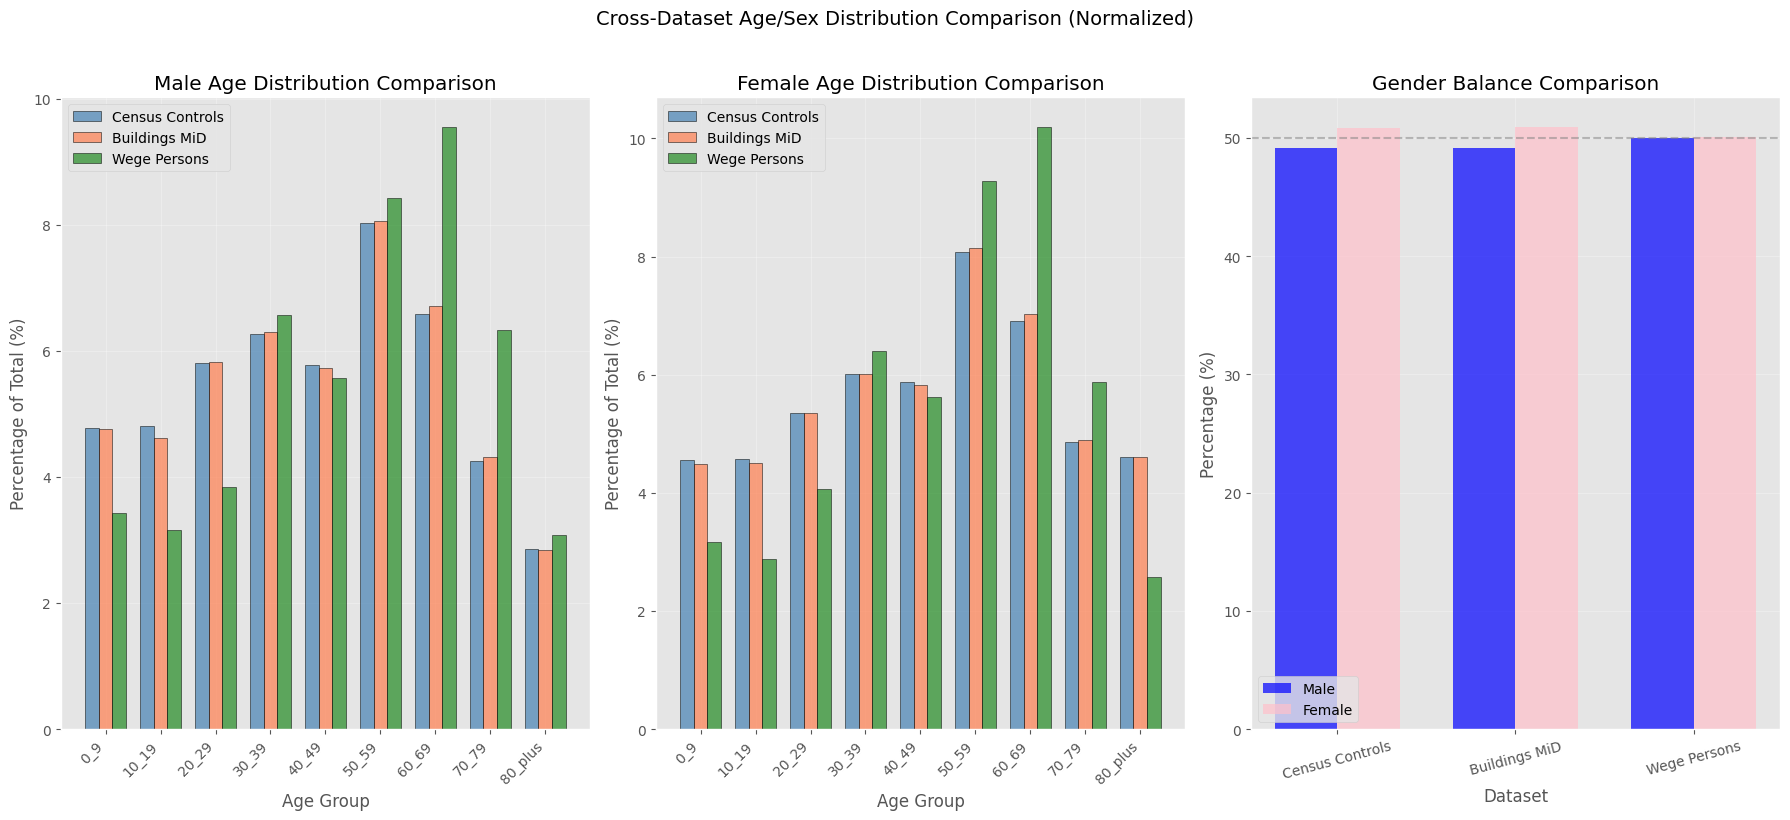

In [37]:
# Cross-dataset comparison: Age-Sex Distribution (NORMALIZED)
# Compare distributions (as percentages) across all data sources

fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Prepare data for comparison - normalize to percentages
datasets = []
labels = []

# Census (always available)
census_m = [census_age_sex[f'M_{a}'] for a in AGE_LABELS]
census_f = [census_age_sex[f'F_{a}'] for a in AGE_LABELS]
census_total = sum(census_m) + sum(census_f)
census_m_pct = [v/census_total*100 for v in census_m]
census_f_pct = [v/census_total*100 for v in census_f]
datasets.append(('Census Controls', census_m_pct, census_f_pct, 'steelblue'))
labels.append('Census')

# Buildings (if available)
if buildings_age_sex is not None:
    bldg_m = [buildings_age_sex[f'M_{a}'] for a in AGE_LABELS]
    bldg_f = [buildings_age_sex[f'F_{a}'] for a in AGE_LABELS]
    bldg_total = sum(bldg_m) + sum(bldg_f)
    if bldg_total > 0:
        bldg_m_pct = [v/bldg_total*100 for v in bldg_m]
        bldg_f_pct = [v/bldg_total*100 for v in bldg_f]
        datasets.append(('Buildings MiD', bldg_m_pct, bldg_f_pct, 'coral'))
        labels.append('Buildings')

# Wege (if available)
if wege_age_sex is not None:
    wege_m = [wege_age_sex[f'M_{a}'] for a in AGE_LABELS]
    wege_f = [wege_age_sex[f'F_{a}'] for a in AGE_LABELS]
    wege_total = sum(wege_m) + sum(wege_f)
    if wege_total > 0:
        wege_m_pct = [v/wege_total*100 for v in wege_m]
        wege_f_pct = [v/wege_total*100 for v in wege_f]
        datasets.append(('Wege Persons', wege_m_pct, wege_f_pct, 'forestgreen'))
        labels.append('Wege')

# Plot 1: Male age distribution comparison
ax1 = axes[0]
x = np.arange(len(AGE_LABELS))
width = 0.25
for i, (name, m_pct, f_pct, color) in enumerate(datasets):
    offset = (i - len(datasets)/2 + 0.5) * width
    ax1.bar(x + offset, m_pct, width, label=name, color=color, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Percentage of Total (%)')
ax1.set_title('Male Age Distribution Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(AGE_LABELS, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Female age distribution comparison
ax2 = axes[1]
for i, (name, m_pct, f_pct, color) in enumerate(datasets):
    offset = (i - len(datasets)/2 + 0.5) * width
    ax2.bar(x + offset, f_pct, width, label=name, color=color, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Percentage of Total (%)')
ax2.set_title('Female Age Distribution Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(AGE_LABELS, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Gender balance comparison
ax3 = axes[2]
gender_data = []
for name, m_pct, f_pct, color in datasets:
    gender_data.append({
        'Dataset': name,
        'Male %': sum(m_pct),
        'Female %': sum(f_pct)
    })
gender_df = pd.DataFrame(gender_data)

x_gender = np.arange(len(gender_df))
width_gender = 0.35
ax3.bar(x_gender - width_gender/2, gender_df['Male %'], width_gender, label='Male', color='blue', alpha=0.7)
ax3.bar(x_gender + width_gender/2, gender_df['Female %'], width_gender, label='Female', color='pink', alpha=0.7)
ax3.set_xlabel('Dataset')
ax3.set_ylabel('Percentage (%)')
ax3.set_title('Gender Balance Comparison')
ax3.set_xticks(x_gender)
ax3.set_xticklabels(gender_df['Dataset'], rotation=15)
ax3.legend()
ax3.axhline(50, color='gray', linestyle='--', alpha=0.5)
ax3.grid(True, alpha=0.3)

plt.suptitle('Cross-Dataset Age/Sex Distribution Comparison (Normalized)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'cross_dataset_age_sex_comparison.png', bbox_inches='tight', dpi=150)
plt.show()

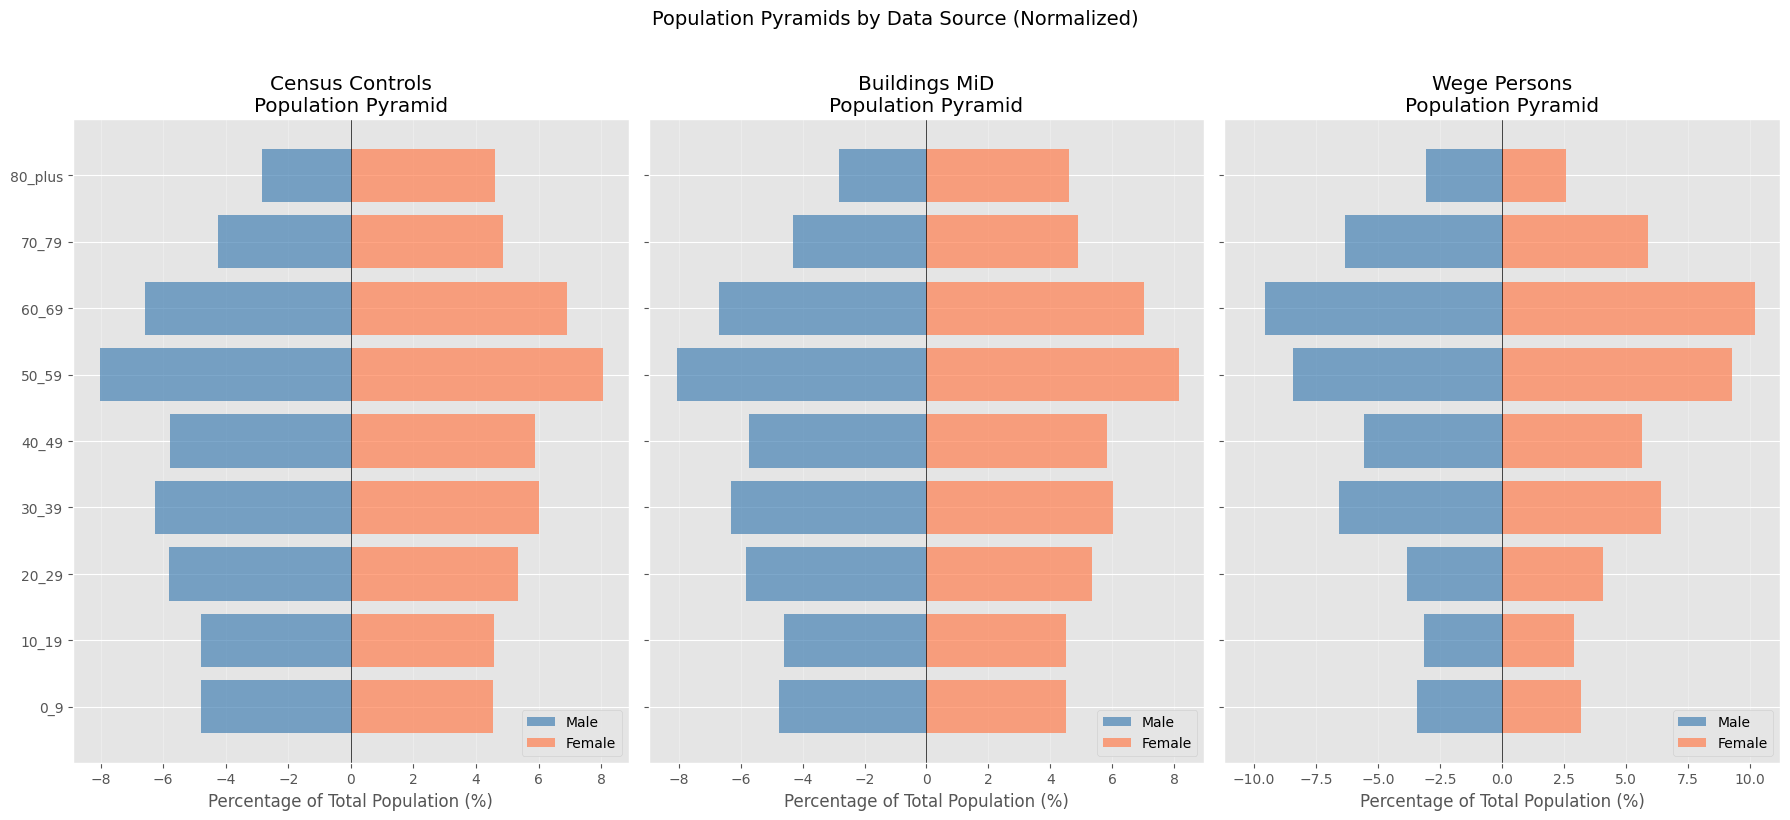

In [38]:
# Population Pyramid Comparison
# Show overlaid pyramids for each data source

fig, axes = plt.subplots(1, len(datasets), figsize=(6*len(datasets), 8), sharey=True)
if len(datasets) == 1:
    axes = [axes]

for idx, (name, m_pct, f_pct, color) in enumerate(datasets):
    ax = axes[idx]
    
    y = np.arange(len(AGE_LABELS))
    
    # Male bars (left side, negative)
    ax.barh(y, [-v for v in m_pct], height=0.8, label='Male', color='steelblue', alpha=0.7)
    # Female bars (right side, positive)
    ax.barh(y, f_pct, height=0.8, label='Female', color='coral', alpha=0.7)
    
    ax.set_yticks(y)
    ax.set_yticklabels(AGE_LABELS)
    ax.set_xlabel('Percentage of Total Population (%)')
    ax.set_title(f'{name}\nPopulation Pyramid')
    ax.legend(loc='lower right')
    
    # Center the x-axis
    max_val = max(max(m_pct), max(f_pct)) * 1.1
    ax.set_xlim(-max_val, max_val)
    ax.axvline(0, color='black', linewidth=0.5)
    ax.grid(True, alpha=0.3, axis='x')

plt.suptitle('Population Pyramids by Data Source (Normalized)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'population_pyramids_comparison.png', bbox_inches='tight', dpi=150)
plt.show()

In [39]:
# Cross-dataset summary table
comparison_rows = []

# Reference: Census
for name, m_pct, f_pct, color in datasets:
    row = {'Dataset': name}
    
    # Total percentages by age
    for i, age in enumerate(AGE_LABELS):
        row[f'M_{age}'] = m_pct[i]
        row[f'F_{age}'] = f_pct[i]
    
    row['Total_M'] = sum(m_pct)
    row['Total_F'] = sum(f_pct)
    
    comparison_rows.append(row)

comparison_df = pd.DataFrame(comparison_rows)
print("Cross-Dataset Age-Sex Distribution (% of total population):\n")
print(comparison_df.to_string(index=False))

# Save to CSV
comparison_df.to_csv(OUTPUT_DIR / 'cross_dataset_age_sex_comparison.csv', index=False)
print(f"\nSaved to {OUTPUT_DIR / 'cross_dataset_age_sex_comparison.csv'}")

Cross-Dataset Age-Sex Distribution (% of total population):

        Dataset    M_0_9    F_0_9  M_10_19  F_10_19  M_20_29  F_20_29  M_30_39  F_30_39  M_40_49  F_40_49  M_50_59  F_50_59  M_60_69   F_60_69  M_70_79  F_70_79  M_80_plus  F_80_plus   Total_M   Total_F
Census Controls 4.776905 4.550798 4.804943 4.579008 5.807093 5.348547 6.271308 6.016151 5.778659 5.882584 8.030560 8.075933 6.584372  6.911619 4.257345 4.869015   2.850079   4.605080 49.161265 50.838735
  Buildings MiD 4.757547 4.491628 4.611807 4.506510 5.817407 5.356992 6.295610 6.008240 5.723457 5.823593 8.057958 8.153534 6.704875  7.032126 4.320761 4.891621   2.836474   4.609860 49.125896 50.874104
   Wege Persons 3.420893 3.165661 3.151450 2.883145 3.836425 4.058686 6.566090 6.409200 5.573588 5.627022 8.430016 9.284955 9.541891 10.187075 6.334734 5.877137   3.084374   2.567659 49.939461 50.060539

Saved to ../validation_results/cross_dataset_age_sex_comparison.csv


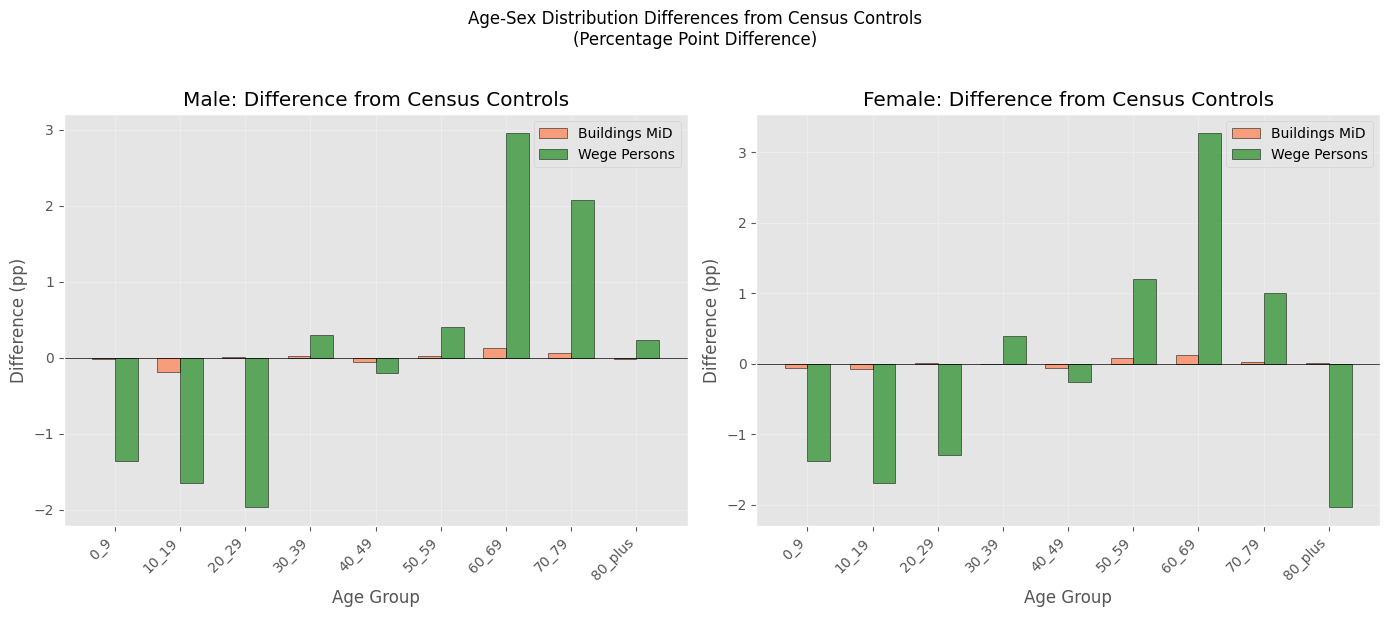

In [40]:
# Difference from Census Controls (percentage point difference)
if len(datasets) > 1:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Reference is Census
    ref_m = datasets[0][1]
    ref_f = datasets[0][2]
    
    x = np.arange(len(AGE_LABELS))
    width = 0.35
    
    for ds_idx, (name, m_pct, f_pct, color) in enumerate(datasets[1:], 1):
        # Male difference
        m_diff = [m_pct[i] - ref_m[i] for i in range(len(AGE_LABELS))]
        # Female difference  
        f_diff = [f_pct[i] - ref_f[i] for i in range(len(AGE_LABELS))]
        
        ax1 = axes[0]
        offset = (ds_idx - 1 - (len(datasets)-2)/2) * width
        bars = ax1.bar(x + offset, m_diff, width, label=name, color=datasets[ds_idx][3], alpha=0.7, edgecolor='black')
        
        ax2 = axes[1]
        bars = ax2.bar(x + offset, f_diff, width, label=name, color=datasets[ds_idx][3], alpha=0.7, edgecolor='black')
    
    ax1.set_xlabel('Age Group')
    ax1.set_ylabel('Difference (pp)')
    ax1.set_title('Male: Difference from Census Controls')
    ax1.set_xticks(x)
    ax1.set_xticklabels(AGE_LABELS, rotation=45, ha='right')
    ax1.legend()
    ax1.axhline(0, color='black', linewidth=0.5)
    ax1.grid(True, alpha=0.3)
    
    ax2.set_xlabel('Age Group')
    ax2.set_ylabel('Difference (pp)')
    ax2.set_title('Female: Difference from Census Controls')
    ax2.set_xticks(x)
    ax2.set_xticklabels(AGE_LABELS, rotation=45, ha='right')
    ax2.legend()
    ax2.axhline(0, color='black', linewidth=0.5)
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('Age-Sex Distribution Differences from Census Controls\n(Percentage Point Difference)', fontsize=12, y=1.02)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'age_sex_diff_from_census.png', bbox_inches='tight', dpi=150)
    plt.show()
else:
    print("Only one dataset available, skipping difference plot.")

## 15. Final Summary

In [41]:
# Final summary of all validation outputs
print("="*80)
print("VALIDATION COMPLETE")
print("="*80)

print("\nOutput files generated:")
output_files = list(OUTPUT_DIR.glob('*'))
for f in sorted(output_files):
    print(f"  - {f.name}")

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

# HH matching
hh_match_pct = (1 - abs(validation_100m['diff'].sum() / validation_100m[hh_control_col].sum())) * 100
print(f"\n1. Household Matching (100m level):")
print(f"   - Control total: {validation_100m[hh_control_col].sum():,.0f}")
print(f"   - Result total: {validation_100m['hh_count'].sum():,.0f}")
print(f"   - Match rate: {hh_match_pct:.2f}%")

# Control statistics summary
if len(all_stats) > 0:
    print(f"\n2. Control Statistics (100m level):")
    print(f"   - Controls validated: {len(all_stats)}")
    print(f"   - Mean RMSE: {stats_df['rmse'].mean():.2f}")
    print(f"   - Mean % difference: {stats_df['mean_pc_difference'].mean():.2f}%")

# Cross-dataset comparison
if len(datasets) > 1:
    print(f"\n3. Cross-Dataset Comparison:")
    for name, m_pct, f_pct, color in datasets:
        total_m = sum(m_pct)
        total_f = sum(f_pct)
        print(f"   - {name}: M={total_m:.1f}%, F={total_f:.1f}%")

print("\n" + "="*80)

VALIDATION COMPLETE

Output files generated:
  - age_sex_diff_from_census.png
  - age_sex_distribution.png
  - control_convergence_stdev.png
  - control_difference_distributions_100m.png
  - control_difference_distributions_1km.png
  - control_validation_stats_100m.csv
  - control_validation_stats_1km.csv
  - cross_dataset_age_sex_comparison.csv
  - cross_dataset_age_sex_comparison.png
  - hh_validation_100m.png
  - population_pyramids_comparison.png
  - validation_summary.csv
  - validation_summary.png

KEY FINDINGS

1. Household Matching (100m level):
   - Control total: 3,816,448
   - Result total: 3,803,578
   - Match rate: 99.66%

2. Control Statistics (100m level):
   - Controls validated: 22
   - Mean RMSE: 1.28
   - Mean % difference: 1134926547054410908351443501056.00%

3. Cross-Dataset Comparison:
   - Census Controls: M=49.2%, F=50.8%
   - Buildings MiD: M=49.1%, F=50.9%
   - Wege Persons: M=49.9%, F=50.1%



---

## End of Validation

All results saved to the `validation_results` directory.

### Output Files:
- `validation_summary.csv` - Overall statistics summary
- `control_validation_stats_100m.csv` - Per-control statistics (100m level)
- `control_validation_stats_1km.csv` - Per-control statistics (1km level)
- `cross_dataset_age_sex_comparison.csv` - Age/sex distribution comparison
- `hh_validation_100m.png` - HH validation scatter/histogram
- `validation_summary.png` - Overall validation plots
- `age_sex_distribution.png` - Age/sex distribution (sample)
- `control_difference_distributions_100m.png` - Per-control diff histograms (100m)
- `control_difference_distributions_1km.png` - Per-control diff histograms (1km)
- `control_convergence_stdev.png` - Control convergence with std dev
- `cross_dataset_age_sex_comparison.png` - Cross-dataset comparison bars
- `population_pyramids_comparison.png` - Population pyramids by source
- `age_sex_diff_from_census.png` - Difference from census controls